# 10 Statistical Testing

## 1 Imports

In [1]:
import os, json
import joblib
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from src.stat_tests import (
    delong_roc_test,
    bootstrap_auc_ci,
    holm_bonferroni,
    compare_aurocs,
)

from src.evaluation import (
    unwrap_best_estimators_non_smote,
    unwrap_best_estimators_smote
)
from src.utils import resolve_path

## 2 Load Data

In [2]:
# ==================================================
# From 06 10 Load Top Models (Baseline + Optimized Variants)
# ==================================================
print("\n📦 Loading all baseline and optimized W2V models for evaluation and interpretation")

# ----------------------------------------------------------
# 1️⃣ Setup
# ----------------------------------------------------------
model_variants = [
    "original_baseline",
    "w2v_radiology_baseline",
    "w2v_optimized_radiology"
]
loaded_models_baseline, loaded_models_smote = {}, {}

# ----------------------------------------------------------
# 2️⃣ Locate and load all *_model.pkl files
# ----------------------------------------------------------
for variant in model_variants:
    variant_dir = Path(resolve_path(f"results/models/{variant}"))
    if not variant_dir.exists():
        print(f"⚠️ No results directory found for {variant} → {variant_dir}")
        continue
    
    subdirs = sorted(
        [p for p in variant_dir.iterdir() if p.is_dir()],
        key=lambda x: x.stat().st_mtime,
        reverse=True
    )
    if not subdirs:
        print(f"⚠️ No run folders found for {variant}")
        continue
    
    latest_run = subdirs[0]
    print(f"📂 Using latest run folder for {variant} → {latest_run.name}")

    pattern = str(resolve_path(f"{latest_run}/*.pkl"))
    all_model_files = [
        f for f in glob.glob(pattern)
        if "_model.pkl" in f and "_full" not in f
    ]
    if not all_model_files:
        print(f"⚠️ No individual model.pkl files found in {latest_run}")
        continue

    for file in all_model_files:
        file_path = Path(file)
        name = file_path.stem
        model = joblib.load(file_path)
        parts = name.split("_")
        # --- Skip any "best" model files (avoid duplicates / meta-wrappers) ---
        if "best" in name.lower():
            print(f"⏭️ Skipping best model file: {file_path.name}")
            continue

        # Detect classifier and SMOTE status
        if name.lower().endswith("smote_model"):
            clf_name = parts[-3]
            # Keep "_baseline" suffix only for the first two variants
            key = f"{variant}_{clf_name}_smote" if "optimized" in variant else f"{variant}_{clf_name}_smote_baseline"
            loaded_models_smote[key] = model
            tag = "SMOTE"
        else:
            clf_name = parts[-2]
            # Similarly, avoid "_baseline" for optimized variant
            key = f"{variant}_{clf_name}" if "optimized" in variant else f"{variant}_{clf_name}"
            loaded_models_baseline[key] = model
            tag = "Baseline"
    
    
        print(f"✅ Loaded {clf_name:<18} | {tag}")

# ----------------------------------------------------------
# 3️⃣ Unwrap nested estimators
# ----------------------------------------------------------
loaded_models_baseline = unwrap_best_estimators_non_smote(loaded_models_baseline)
loaded_models_smote    = unwrap_best_estimators_smote(loaded_models_smote)

# ----------------------------------------------------------
# 4️⃣ Summary + manifest
# ----------------------------------------------------------
print("\n📊 Summary of loaded models")
print(f"Baseline models → {len(loaded_models_baseline)}")
print(f"SMOTE models    → {len(loaded_models_smote)}")
print("Baseline keys:", list(loaded_models_baseline.keys()))
print("SMOTE keys:", list(loaded_models_smote.keys()))

manifest = {
    "baseline_keys": list(loaded_models_baseline.keys()),
    "smote_keys": list(loaded_models_smote.keys()),
}
manifest_path = Path(resolve_path("results/models/comparisons/loaded_models_manifest.json"))
manifest_path.parent.mkdir(parents=True, exist_ok=True)
with open(manifest_path, "w") as f:
    json.dump(manifest, f, indent=2)
#mlflow.log_artifact(str(manifest_path), artifact_path="summaries")
print(f"💾 Logged loaded models manifest → {manifest_path}")

# ==================================================
# From 06 12 Prepare Representative Sample Data
# ==================================================

# --------------------------------------------------
# Drop unwanted columns from optimized variant (clean before load)
# --------------------------------------------------
drop_cols = ["first_hosp_stay", "suspected_infection", "sepsis3", "subject_id"]

# Paths for optimized variant datasets
opt_train_path = resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_xtrain.csv")
opt_train_res_path = resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_xtrain_res.csv")
opt_test_path = resolve_path("data/processed/w2v_optimized_radiology/data_w2v_optimized_radiology_xtest.csv")

def clean_and_overwrite(path: Path, label: str):
    if path.exists():
        df = pd.read_csv(path)
        df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
        df.to_csv(path, index=False)
        print(f"✅ Cleaned and overwrote {path.name} ({label}; dropped id/flags)")
    else:
        print(f"⚠️ Missing file for {label} → {path}")

# Clean all optimized variant datasets first
clean_and_overwrite(opt_train_path, "X_train")
clean_and_overwrite(opt_train_res_path, "X_train_resampled")
clean_and_overwrite(opt_test_path, "X_test")


# --------------------------------------------------
# Now load processed test data (all three variants)
# --------------------------------------------------
variants = ["original", "w2v_radiology", "w2v_optimized_radiology"]
X_tests, y_tests = {}, {}

for variant in variants:
    x_path = resolve_path(f"data/processed/{variant}/data_{variant}_xtest.csv")
    y_path = resolve_path(f"data/processed/{variant}/data_{variant}_ytest.csv")
    
    if x_path.exists() and y_path.exists():
        X_tests[variant] = pd.read_csv(x_path)
        y_tests[variant] = pd.read_csv(y_path).squeeze()
        print(f"✅ Loaded test data for {variant}: {X_tests[variant].shape}")
    else:
        print(f"⚠️ Missing test data for {variant}")


📦 Loading all baseline and optimized W2V models for evaluation and interpretation
📂 Using latest run folder for original_baseline → original_baseline_20251027_0818
⏭️ Skipping best model file: original_baseline_20251027_0818_best_model.pkl
⏭️ Skipping best model file: original_baseline_20251027_0818_best_smote_model.pkl
✅ Loaded CatBoost           | Baseline
✅ Loaded CatBoost           | SMOTE
✅ Loaded DecisionTree       | Baseline
✅ Loaded DecisionTree       | SMOTE
✅ Loaded GradientBoosting   | Baseline
✅ Loaded GradientBoosting   | SMOTE
✅ Loaded LGBM               | Baseline
✅ Loaded LGBM               | SMOTE
✅ Loaded LogisticRegression | Baseline
✅ Loaded LogisticRegression | SMOTE
✅ Loaded MLP                | Baseline
✅ Loaded MLP                | SMOTE
✅ Loaded NaiveBayes         | Baseline
✅ Loaded NaiveBayes         | SMOTE
✅ Loaded RandomForest       | Baseline
✅ Loaded RandomForest       | SMOTE
✅ Loaded SVC                | Baseline
✅ Loaded SVC                | SMOTE
✅ 

In [3]:
# ==================================================
# ✅ Generate and Save Holdout Probabilities (Baseline + SMOTE)
# ==================================================
from pathlib import Path
import json
import numpy as np

out_dir = Path(resolve_path("results/evaluation/predictions"))
out_dir.mkdir(parents=True, exist_ok=True)

# --- optional normalization map ---
NAME_MAP = {
    "RandomForestClassifier": "RandomForest",
    "GradientBoostingClassifier": "GradientBoosting",
    "LogisticRegressionCV": "LogisticRegression",
    "LGBMClassifier": "LGBM",
    "XGBClassifier": "XGB",
    "CatBoostClassifier": "CatBoost",
    "RandomForest": "RandomForest",
    "GradientBoosting": "GradientBoosting",
    "LogisticRegression": "LogisticRegression",
    "LGBM": "LGBM",
    "XGB": "XGB",
    "CatBoost": "CatBoost",
    "SVC": "SVC",
}

def extract_clf_from_key(k: str) -> str:
    """Extract classifier name from a loaded_models_* key."""
    parts = k.split("_")
    if parts[-1] == "smote":
        clf = parts[-2]
    elif parts[-1] == "baseline" and "smote" in parts:
        clf = parts[-3]
    else:
        clf = parts[-1]
    return NAME_MAP.get(clf, clf)

def generate_holdout_json(loaded_models, variant_label, is_smote=False):
    """Create and save per-classifier probability predictions."""
    tag = "SMOTE" if is_smote else "Baseline"
    print(f"\n📊 Generating holdout predictions for {variant_label} [{tag}]")

    X_test = X_tests.get(variant_label)
    y_test = y_tests.get(variant_label)
    if X_test is None or y_test is None:
        print(f"⚠️ No test data for {variant_label}")
        return

    results = {}
    for key, model in loaded_models.items():
        if variant_label not in key:
            continue

        # ✅ robust classifier name extraction
        clf_name = extract_clf_from_key(key)
        try:
            clf = model.named_steps.get("clf", model) if hasattr(model, "named_steps") else model
            if hasattr(clf, "predict_proba"):
                y_proba = clf.predict_proba(X_test)[:, 1]
            elif hasattr(clf, "decision_function"):
                s = clf.decision_function(X_test)
                y_proba = (s - s.min()) / (s.max() - s.min() + 1e-12)
            else:
                print(f"⚠️ {clf_name} has no predict_proba or decision_function.")
                continue

            auc = roc_auc_score(y_test, y_proba)
            results[clf_name] = y_proba.tolist()
            print(f"✅ {clf_name:<20} AUROC = {auc:.3f}")
        except Exception as e:
            print(f"⚠️ {clf_name} failed: {e}")

    suffix = "_smote" if is_smote else ""
    out_path = out_dir / f"{variant_label}_holdout_probs{suffix}.json"
    out_path.write_text(json.dumps(results, indent=2))
    print(f"💾 Saved {len(results)} classifiers → {out_path}")

# ---- Baseline ----
for v in ["original", "w2v_radiology", "w2v_optimized_radiology"]:
    generate_holdout_json(loaded_models_baseline, v, is_smote=False)

# ---- SMOTE ----
for v in ["original", "w2v_radiology", "w2v_optimized_radiology"]:
    generate_holdout_json(loaded_models_smote, v, is_smote=True)

print("\n📦 Finished exporting holdout probability JSONs (Baseline + SMOTE).")



📊 Generating holdout predictions for original [Baseline]
✅ CatBoost             AUROC = 0.734
✅ DecisionTree         AUROC = 0.635
✅ GradientBoosting     AUROC = 0.727
✅ LGBM                 AUROC = 0.726
✅ LogisticRegression   AUROC = 0.723
✅ MLP                  AUROC = 0.695
✅ NaiveBayes           AUROC = 0.701
✅ RandomForest         AUROC = 0.726
✅ SVC                  AUROC = 0.688
✅ XGB                  AUROC = 0.729
💾 Saved 10 classifiers → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\evaluation\predictions\original_holdout_probs.json

📊 Generating holdout predictions for w2v_radiology [Baseline]
✅ CatBoost             AUROC = 0.757
✅ DecisionTree         AUROC = 0.598
✅ GradientBoosting     AUROC = 0.753
✅ LGBM                 AUROC = 0.750
✅ LogisticRegression   AUROC = 0.752
✅ MLP                  AUROC = 0.735
✅ NaiveBayes           AUROC = 0.673
✅ RandomForest         AUROC = 0.733
✅ SVC                  AUROC = 0.731
✅ XGB   

In [4]:
# Example: use optimized W2V NON-SMOTE track on the shared holdout
variant = "w2v_optimized_radiology"
y_true = pd.read_csv(resolve_path(f"data/processed/{variant}/data_{variant}_ytest.csv")).squeeze()

# Collect probabilities per classifier for EACH VARIANT on the SAME subjects
# If your three variants have different feature spaces, compute probs on their own test sets but
# for DeLong paired tests you must compare predictions on the SAME y_true.
# Recommended: restrict to the common holdout index if available.

# ==================================================
# ✅ Corrected Block: Regenerate SMOTE probability JSONs
# ==================================================

# --- helper name normalization map ---
NAME_MAP = {
    "RandomForestClassifier":"RandomForest",
    "GradientBoostingClassifier":"GradientBoosting",
    "LogisticRegressionCV":"LogisticRegression",
    "LGBMClassifier":"LGBM",
    "XGBClassifier":"XGB",
    "CatBoostClassifier":"CatBoost",
    "RandomForest":"RandomForest",
    "GradientBoosting":"GradientBoosting",
    "LogisticRegression":"LogisticRegression",
    "LGBM":"LGBM",
    "XGB":"XGB",
    "CatBoost":"CatBoost",
    "SVC":"SVC",
}

def extract_clf_from_key(k: str) -> str:
    """Extract classifier name from a loaded_models_smote key (handles all suffix patterns)."""
    parts = k.split("_")
    if parts[-1] == "smote":
        clf = parts[-2]
    elif parts[-1] == "baseline" and "smote" in parts:
        clf = parts[-3]
    else:
        clf = parts[-1]
    return NAME_MAP.get(clf, clf)

def safe_proba(m, X):
    clf = m.named_steps.get("clf", m) if hasattr(m, "named_steps") else m
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:, 1]
    if hasattr(clf, "decision_function"):
        s = clf.decision_function(X)
        return (s - s.min()) / (s.max() - s.min() + 1e-12)
    raise ValueError("No predict_proba or decision_function")

def collect_probs(loaded_dict, variant: str, smote: bool) -> dict:
    """Collect {classifier: prob list} for the given variant (SMOTE or non-SMOTE)."""
    out = {}
    X = X_tests.get(variant)
    if X is None:
        print(f"⚠️ Missing X_test for {variant}")
        return out
    for k, model in loaded_dict.items():
        if variant not in k:
            continue
        # filter by smote vs baseline keys
        has_smote = "_smote" in k
        if has_smote != smote:
            continue
        clf_name = extract_clf_from_key(k)
        try:
            out[clf_name] = safe_proba(model, X).tolist()
        except Exception as e:
            print(f"[skip {variant} {clf_name}] {e}")
    return out

# --- write all corrected JSONs ---
p_dir = Path(resolve_path("results/evaluation/predictions/"))
p_dir.mkdir(parents=True, exist_ok=True)

# Non-SMOTE
orig_ns = collect_probs(loaded_models_baseline, "original", smote=False)
w2v_ns  = collect_probs(loaded_models_baseline, "w2v_radiology", smote=False)
opt_ns  = collect_probs(loaded_models_baseline, "w2v_optimized_radiology", smote=False)

(p_dir / "original_holdout_probs.json").write_text(json.dumps(orig_ns))
(p_dir / "w2v_radiology_holdout_probs.json").write_text(json.dumps(w2v_ns))
(p_dir / "w2v_optimized_radiology_holdout_probs.json").write_text(json.dumps(opt_ns))
print("💾 Wrote non-SMOTE JSONs:", sorted(orig_ns.keys()))

# SMOTE
orig_s = collect_probs(loaded_models_smote, "original", smote=True)
w2v_s  = collect_probs(loaded_models_smote, "w2v_radiology", smote=True)
opt_s  = collect_probs(loaded_models_smote, "w2v_optimized_radiology", smote=True)

(p_dir / "original_holdout_probs_smote.json").write_text(json.dumps(orig_s))
(p_dir / "w2v_radiology_holdout_probs_smote.json").write_text(json.dumps(w2v_s))
(p_dir / "w2v_optimized_radiology_holdout_probs_smote.json").write_text(json.dumps(opt_s))
print("💾 Wrote SMOTE JSONs:", sorted(orig_s.keys()))


💾 Wrote non-SMOTE JSONs: ['CatBoost', 'DecisionTree', 'GradientBoosting', 'LGBM', 'LogisticRegression', 'MLP', 'NaiveBayes', 'RandomForest', 'SVC', 'XGB']
💾 Wrote SMOTE JSONs: ['CatBoost', 'DecisionTree', 'GradientBoosting', 'LGBM', 'LogisticRegression', 'MLP', 'NaiveBayes', 'RandomForest', 'SVC', 'XGB']


In [5]:
# ==================================================
# Reload Holdout Probabilities (Baseline and SMOTE)
# for Statistical Testing (Task 11)
# ==================================================

p_dir = resolve_path("results/evaluation/predictions")

# --- Non-SMOTE ---
probs_original_path = Path(p_dir) / "original_holdout_probs.json"
probs_w2v_path      = Path(p_dir) / "w2v_radiology_holdout_probs.json"
probs_opt_path      = Path(p_dir) / "w2v_optimized_radiology_holdout_probs.json"

probs_original = json.loads(probs_original_path.read_text())
probs_w2v      = json.loads(probs_w2v_path.read_text())
probs_w2v_opt  = json.loads(probs_opt_path.read_text())

# Convert to NumPy arrays
probs_original = {k: np.asarray(v) for k, v in probs_original.items()}
probs_w2v      = {k: np.asarray(v) for k, v in probs_w2v.items()}
probs_w2v_opt  = {k: np.asarray(v) for k, v in probs_w2v_opt.items()}

# --- SMOTE ---
probs_original_smote_path = Path(p_dir) / "original_holdout_probs_smote.json"
probs_w2v_smote_path      = Path(p_dir) / "w2v_radiology_holdout_probs_smote.json"
probs_opt_smote_path      = Path(p_dir) / "w2v_optimized_radiology_holdout_probs_smote.json"

probs_original_smote = json.loads(probs_original_smote_path.read_text())
probs_w2v_smote      = json.loads(probs_w2v_smote_path.read_text())
probs_w2v_opt_smote  = json.loads(probs_opt_smote_path.read_text())

probs_original_smote = {k: np.asarray(v) for k, v in probs_original_smote.items()}
probs_w2v_smote      = {k: np.asarray(v) for k, v in probs_w2v_smote.items()}
probs_w2v_opt_smote  = {k: np.asarray(v) for k, v in probs_w2v_opt_smote.items()}

# --- Intersect classifier lists ---
classifiers = sorted(set(probs_original) & set(probs_w2v) & set(probs_w2v_opt))
classifiers_smote = sorted(set(probs_original_smote) & set(probs_w2v_smote) & set(probs_w2v_opt_smote))

print(f"✅ Loaded baseline probability sets for {len(classifiers)} classifiers:")
print(classifiers)
print(f"✅ Loaded SMOTE probability sets for {len(classifiers_smote)} classifiers:")
print(classifiers_smote)


✅ Loaded baseline probability sets for 6 classifiers:
['CatBoost', 'GradientBoosting', 'LGBM', 'LogisticRegression', 'RandomForest', 'XGB']
✅ Loaded SMOTE probability sets for 6 classifiers:
['CatBoost', 'GradientBoosting', 'LGBM', 'LogisticRegression', 'RandomForest', 'XGB']


## 3 Comparison Tests

In [6]:
pairs = []
# ==================================================
# Recreate classifier list from probability dicts
# ==================================================
classifiers = sorted(
    set(probs_original.keys())
    & set(probs_w2v.keys())
    & set(probs_w2v_opt.keys())
)

print(f"✅ Found {len(classifiers)} classifiers for DeLong comparisons:")
print(classifiers)

for clf in classifiers:
    # Compare optimized vs original, optimized vs w2v (both paired on same y_true)
    pairs.append((f"opt::{clf}", f"orig::{clf}"))
    pairs.append((f"opt::{clf}", f"w2v::{clf}"))

model_probs = {}
for clf in classifiers:
    model_probs[f"orig::{clf}"] = probs_original[clf]
    model_probs[f"w2v::{clf}"]  = probs_w2v[clf]
    model_probs[f"opt::{clf}"]  = probs_w2v_opt[clf]

df_delong = compare_aurocs(model_probs, y_true, pairs, method="delong")
display(df_delong)

✅ Found 6 classifiers for DeLong comparisons:
['CatBoost', 'GradientBoosting', 'LGBM', 'LogisticRegression', 'RandomForest', 'XGB']


,model_a,model_b,auc_a,auc_b,delta,se_delta,z,p_value,ci_low,ci_high,method
0,opt::CatBoost,orig::CatBoost,0.756233,0.734284,0.021949,0.011831,1.855152,0.063574,NaN,NaN,delong
1,opt::CatBoost,w2v::CatBoost,0.756233,0.756803,-0.000570,0.007905,-0.072084,0.942535,NaN,NaN,delong
2,opt::GradientBoosting,orig::GradientBoosting,0.752431,0.726701,0.025730,0.012251,2.100344,0.035699,NaN,NaN,delong
3,opt::GradientBoosting,w2v::GradientBoosting,0.752431,0.753368,-0.000938,0.008504,-0.110262,0.912202,NaN,NaN,delong
4,opt::LGBM,orig::LGBM,0.743091,0.725975,0.017116,0.013737,1.245935,0.212788,NaN,NaN,delong
5,opt::LGBM,w2v::LGBM,0.743091,0.749913,-0.006822,0.009765,-0.698685,0.484749,NaN,NaN,delong
6,opt::LogisticRegression,orig::LogisticRegression,0.756984,0.723406,0.033578,0.011916,2.817941,0.004833,NaN,NaN,delong
7,opt::LogisticRegression,w2v::LogisticRegression,0.756984,0.752343,0.004642,0.006804,0.682150,0.495144,NaN,NaN,delong
8,opt::RandomForest,orig::RandomForest,0.736077,0.726405,0.009672,0.012365,0.782151,0.434126,NaN,NaN,delong
9,opt::RandomForest,w2v::RandomForest,0.736077,0.732508,0.003569,0.007405,0.481975,0.629824,NaN,NaN,delong


In [7]:
# ==================================================
# ✅ Paired DeLong Tests — SMOTE (optimized vs baselines)
# ==================================================
pairs_smote = []

# --------------------------------------------------
# Recreate classifier list from SMOTE probability dicts
# --------------------------------------------------
classifiers_smote = sorted(
    set(probs_original_smote.keys())
    & set(probs_w2v_smote.keys())
    & set(probs_w2v_opt_smote.keys())
)

print(f"✅ Found {len(classifiers_smote)} classifiers for DeLong SMOTE comparisons:")
print(classifiers_smote)

# Build comparison pairs (optimized vs original / optimized vs w2v)
for clf in classifiers_smote:
    pairs_smote.append((f"opt::{clf}", f"orig::{clf}"))
    pairs_smote.append((f"opt::{clf}", f"w2v::{clf}"))

# --------------------------------------------------
# Map classifier → probability arrays
# --------------------------------------------------
model_probs_smote = {}
for clf in classifiers_smote:
    model_probs_smote[f"orig::{clf}"] = probs_original_smote[clf]
    model_probs_smote[f"w2v::{clf}"]  = probs_w2v_smote[clf]
    model_probs_smote[f"opt::{clf}"]  = probs_w2v_opt_smote[clf]

# --------------------------------------------------
# Run DeLong comparisons
# --------------------------------------------------
df_delong_smote = compare_aurocs(model_probs_smote, y_true, pairs_smote, method="delong")
display(df_delong_smote.head())

print("✅ Completed SMOTE DeLong comparisons (optimized vs baseline variants).")


✅ Found 6 classifiers for DeLong SMOTE comparisons:
['CatBoost', 'GradientBoosting', 'LGBM', 'LogisticRegression', 'RandomForest', 'XGB']


,model_a,model_b,auc_a,auc_b,delta,se_delta,z,p_value,ci_low,ci_high,method
0,opt::CatBoost,orig::CatBoost,0.736325,0.724805,0.011521,0.012253,0.940253,0.347088,NaN,NaN,delong
1,opt::CatBoost,w2v::CatBoost,0.736325,0.741247,-0.004921,0.008119,-0.606166,0.544405,NaN,NaN,delong
2,opt::GradientBoosting,orig::GradientBoosting,0.734248,0.703203,0.031045,0.013391,2.318412,0.020427,NaN,NaN,delong
3,opt::GradientBoosting,w2v::GradientBoosting,0.734248,0.721349,0.012899,0.009160,1.408154,0.159085,NaN,NaN,delong
4,opt::LGBM,orig::LGBM,0.750701,0.709917,0.040784,0.013904,2.933227,0.003355,NaN,NaN,delong


✅ Completed SMOTE DeLong comparisons (optimized vs baseline variants).


## 4 Holm–Bonferroni across all DeLong tests

In [8]:
# ==================================================
# Holm–Bonferroni correction for multiple comparisons
# ==================================================
from statsmodels.stats.multitest import multipletests

# Only correct real p-values (not NaN)
df_delong["p_holm"] = np.nan
mask_valid = df_delong["p_value"].notna()
df_delong.loc[mask_valid, "p_holm"] = multipletests(
    df_delong.loc[mask_valid, "p_value"], method="holm"
)[1]

# Flag significance
df_delong["significant (0.05, Holm)"] = df_delong["p_holm"] < 0.05

display(df_delong.head(10))
print("✅ Applied Holm–Bonferroni correction across all DeLong tests.")


,model_a,model_b,auc_a,auc_b,delta,se_delta,z,p_value,ci_low,ci_high,method,p_holm,"significant (0.05, Holm)"
0,opt::CatBoost,orig::CatBoost,0.756233,0.734284,0.021949,0.011831,1.855152,0.063574,NaN,NaN,delong,0.635745,False
1,opt::CatBoost,w2v::CatBoost,0.756233,0.756803,-0.000570,0.007905,-0.072084,0.942535,NaN,NaN,delong,1.000000,False
2,opt::GradientBoosting,orig::GradientBoosting,0.752431,0.726701,0.025730,0.012251,2.100344,0.035699,NaN,NaN,delong,0.392684,False
3,opt::GradientBoosting,w2v::GradientBoosting,0.752431,0.753368,-0.000938,0.008504,-0.110262,0.912202,NaN,NaN,delong,1.000000,False
4,opt::LGBM,orig::LGBM,0.743091,0.725975,0.017116,0.013737,1.245935,0.212788,NaN,NaN,delong,1.000000,False
5,opt::LGBM,w2v::LGBM,0.743091,0.749913,-0.006822,0.009765,-0.698685,0.484749,NaN,NaN,delong,1.000000,False
6,opt::LogisticRegression,orig::LogisticRegression,0.756984,0.723406,0.033578,0.011916,2.817941,0.004833,NaN,NaN,delong,0.057999,False
7,opt::LogisticRegression,w2v::LogisticRegression,0.756984,0.752343,0.004642,0.006804,0.682150,0.495144,NaN,NaN,delong,1.000000,False
8,opt::RandomForest,orig::RandomForest,0.736077,0.726405,0.009672,0.012365,0.782151,0.434126,NaN,NaN,delong,1.000000,False
9,opt::RandomForest,w2v::RandomForest,0.736077,0.732508,0.003569,0.007405,0.481975,0.629824,NaN,NaN,delong,1.000000,False


✅ Applied Holm–Bonferroni correction across all DeLong tests.


In [9]:
# ==================================================
# ✅ Holm–Bonferroni correction for SMOTE DeLong tests
# ==================================================
from statsmodels.stats.multitest import multipletests

# Initialize new column
df_delong_smote["p_holm"] = np.nan

# Apply Holm–Bonferroni only to valid p-values
mask_valid_smote = df_delong_smote["p_value"].notna()
df_delong_smote.loc[mask_valid_smote, "p_holm"] = multipletests(
    df_delong_smote.loc[mask_valid_smote, "p_value"], method="holm"
)[1]

# Flag significance at α = 0.05
df_delong_smote["significant (0.05, Holm)"] = df_delong_smote["p_holm"] < 0.05

# Display preview
display(df_delong_smote.head(10))
print("✅ Applied Holm–Bonferroni correction across all SMOTE DeLong tests.")


,model_a,model_b,auc_a,auc_b,delta,se_delta,z,p_value,ci_low,ci_high,method,p_holm,"significant (0.05, Holm)"
0,opt::CatBoost,orig::CatBoost,0.736325,0.724805,0.011521,0.012253,0.940253,0.347088,NaN,NaN,delong,1.000000,False
1,opt::CatBoost,w2v::CatBoost,0.736325,0.741247,-0.004921,0.008119,-0.606166,0.544405,NaN,NaN,delong,1.000000,False
2,opt::GradientBoosting,orig::GradientBoosting,0.734248,0.703203,0.031045,0.013391,2.318412,0.020427,NaN,NaN,delong,0.142989,False
3,opt::GradientBoosting,w2v::GradientBoosting,0.734248,0.721349,0.012899,0.009160,1.408154,0.159085,NaN,NaN,delong,0.954513,False
4,opt::LGBM,orig::LGBM,0.750701,0.709917,0.040784,0.013904,2.933227,0.003355,NaN,NaN,delong,0.036900,True
5,opt::LGBM,w2v::LGBM,0.750701,0.737128,0.013572,0.009898,1.371250,0.170297,NaN,NaN,delong,0.954513,False
6,opt::LogisticRegression,orig::LogisticRegression,0.753001,0.716185,0.036816,0.013326,2.762643,0.005734,NaN,NaN,delong,0.051602,False
7,opt::LogisticRegression,w2v::LogisticRegression,0.753001,0.747577,0.005424,0.008421,0.644039,0.519550,NaN,NaN,delong,1.000000,False
8,opt::RandomForest,orig::RandomForest,0.737056,0.702074,0.034982,0.013565,2.578852,0.009913,NaN,NaN,delong,0.079303,False
9,opt::RandomForest,w2v::RandomForest,0.737056,0.713325,0.023731,0.008344,2.844073,0.004454,NaN,NaN,delong,0.044541,True


✅ Applied Holm–Bonferroni correction across all SMOTE DeLong tests.


## 5 Bootstrap CIs

In [10]:
# Compute bootstrap CIs for each classifier (95%)
records_ci = []
for clf in classifiers:
    for label, probs in {
        "opt": probs_w2v_opt[clf],
        "w2v": probs_w2v[clf],
        "orig": probs_original[clf],
    }.items():
        ci = bootstrap_auc_ci(y_true, probs, n_boot=2000, alpha=0.95, stratified=True)
        records_ci.append({
            "Classifier": clf,
            "Variant": label,
            "AUROC": ci["auc"],
            "SE": ci["se"],
            "CI_low": ci["ci_low"],
            "CI_high": ci["ci_high"],
        })

df_ci = pd.DataFrame(records_ci)
display(df_ci.head())
print("✅ Bootstrapped stratified 95% CIs computed for all classifiers.")


,Classifier,Variant,AUROC,SE,CI_low,CI_high
0,CatBoost,opt,0.756233,0.016171,0.724566,0.787151
1,CatBoost,w2v,0.756803,0.015937,0.724077,0.787961
2,CatBoost,orig,0.734284,0.016911,0.700052,0.767640
3,GradientBoosting,opt,0.752431,0.016675,0.718738,0.785213
4,GradientBoosting,w2v,0.753368,0.016285,0.721071,0.784305


✅ Bootstrapped stratified 95% CIs computed for all classifiers.


In [11]:
display(df_ci)

,Classifier,Variant,AUROC,SE,CI_low,CI_high
0,CatBoost,opt,0.756233,0.016171,0.724566,0.787151
1,CatBoost,w2v,0.756803,0.015937,0.724077,0.787961
2,CatBoost,orig,0.734284,0.016911,0.700052,0.767640
3,GradientBoosting,opt,0.752431,0.016675,0.718738,0.785213
4,GradientBoosting,w2v,0.753368,0.016285,0.721071,0.784305
5,GradientBoosting,orig,0.726701,0.017304,0.691966,0.760287
6,LGBM,opt,0.743091,0.016781,0.710329,0.775709
7,LGBM,w2v,0.749913,0.016641,0.716374,0.782048
8,LGBM,orig,0.725975,0.017163,0.691725,0.759443
9,LogisticRegression,opt,0.756984,0.016291,0.724849,0.789092


In [12]:
# ==================================================
# ✅ Bootstrap 95% AUROC Confidence Intervals — SMOTE
# ==================================================

records_ci_smote = []
for clf in classifiers_smote:
    for label, probs in {
        "opt": probs_w2v_opt_smote[clf],
        "w2v": probs_w2v_smote[clf],
        "orig": probs_original_smote[clf],
    }.items():
        ci = bootstrap_auc_ci(y_true, probs, n_boot=2000, alpha=0.95, stratified=True)
        records_ci_smote.append({
            "Classifier": clf,
            "Variant": label,
            "AUROC": ci["auc"],
            "SE": ci["se"],
            "CI_low": ci["ci_low"],
            "CI_high": ci["ci_high"],
        })

df_ci_smote = pd.DataFrame(records_ci_smote)
display(df_ci_smote.head())
print("✅ Bootstrapped stratified 95% CIs computed for all SMOTE classifiers.")


,Classifier,Variant,AUROC,SE,CI_low,CI_high
0,CatBoost,opt,0.736325,0.016743,0.704186,0.769783
1,CatBoost,w2v,0.741247,0.016438,0.708636,0.772186
2,CatBoost,orig,0.724805,0.017020,0.692460,0.757011
3,GradientBoosting,opt,0.734248,0.016720,0.701609,0.766988
4,GradientBoosting,w2v,0.721349,0.016964,0.688653,0.753143


✅ Bootstrapped stratified 95% CIs computed for all SMOTE classifiers.


In [13]:
display(df_ci_smote)

,Classifier,Variant,AUROC,SE,CI_low,CI_high
0,CatBoost,opt,0.736325,0.016743,0.704186,0.769783
1,CatBoost,w2v,0.741247,0.016438,0.708636,0.772186
2,CatBoost,orig,0.724805,0.017020,0.692460,0.757011
3,GradientBoosting,opt,0.734248,0.016720,0.701609,0.766988
4,GradientBoosting,w2v,0.721349,0.016964,0.688653,0.753143
5,GradientBoosting,orig,0.703203,0.017868,0.668335,0.738354
6,LGBM,opt,0.750701,0.016159,0.719312,0.781891
7,LGBM,w2v,0.737128,0.016573,0.704583,0.768444
8,LGBM,orig,0.709917,0.017579,0.674980,0.742798
9,LogisticRegression,opt,0.753001,0.016468,0.719494,0.784872


# 6 Merge DeLong and Bootstrap Summary Tables

In [14]:
# ==================================================
# 🧩 Clean Merge between DeLong Results and Bootstrap CIs
# ==================================================

# Extract classifier and variant (e.g., "opt::CatBoost" → "opt", "CatBoost")
df_delong["Classifier"] = df_delong["model_a"].str.split("::").str[-1]
df_delong["Variant"] = df_delong["model_a"].str.split("::").str[0]

# ---- Drop old CI columns to prevent suffixing ----
for c in ["ci_low", "ci_high", "ci_low_x", "ci_high_x", "ci_low_y", "ci_high_y"]:
    if c in df_delong.columns:
        df_delong.drop(columns=c, inplace=True)

# ---- Normalize CI column names in df_ci ----
rename_map = {
    "AUROC": "auc_ci",
    "AUC": "auc_ci",
    "SE": "se_auc",
    "Se": "se_auc",
    "CI_low": "ci_low",
    "ci_low": "ci_low",
    "CI_high": "ci_high",
    "ci_high": "ci_high",
}
df_ci.rename(columns={k: v for k, v in rename_map.items() if k in df_ci.columns}, inplace=True)

# ---- Merge DeLong + CI results safely (no suffixes) ----
df_summary_full = pd.merge(
    df_delong,
    df_ci[["Classifier", "Variant", "auc_ci", "se_auc", "ci_low", "ci_high"]],
    how="left",
    on=["Classifier", "Variant"],
    validate="m:1"
)

# ==================================================
# 🧾 Label Comparisons and Add Formatted CI String
# ==================================================
def extract_variant_label(row):
    """Readable comparison label."""
    b = row["model_b"]
    if b.startswith("orig::"):
        return "opt vs original"
    elif b.startswith("w2v::"):
        return "opt vs w2v"
    return "unknown"

df_summary_full["Comparison"] = df_summary_full.apply(extract_variant_label, axis=1)

# Formatted 95% CI string (exact 3-decimal values)
df_summary_full["AUROC ± SE (95% CI)"] = (
    df_summary_full["auc_a"].map("{:.5f}".format)
    + " ± " + df_summary_full["se_auc"].map("{:.4f}".format)
    + " [" + df_summary_full["ci_low"].map("{:.4f}".format)
    + "–" + df_summary_full["ci_high"].map("{:.4f}".format) + "]"
)

# ==================================================
# ✨ Create Display and Export Versions
# ==================================================
# Display-ready table (cleaned, renamed columns)
df_summary_display = df_summary_full[
    [
        "Classifier",
        "Comparison",
        "auc_a", "auc_b", "delta",
        "se_delta", "z", "p_value", "p_holm",
        "significant (0.05, Holm)",
        "AUROC ± SE (95% CI)",
        "method",
    ]
].rename(columns={
    "auc_a": "AUROC (opt)",
    "auc_b": "AUROC (baseline)",
    "delta": "ΔAUROC (opt - baseline)",
    "se_delta": "SE (Δ)",
    "p_value": "p (DeLong)"
})

# Sort and filter display table
df_summary_display = (
    df_summary_display
    .sort_values(["Classifier", "Comparison"])
    .reset_index(drop=True)
)
df_summary_display = df_summary_display[df_summary_display["Classifier"].str.lower() != "best"].reset_index(drop=True)

# Keep "best" filtered but preserve full version
df_summary_full = df_summary_full[df_summary_full["Classifier"].str.lower() != "best"].reset_index(drop=True)

# ==================================================
# ✅ Output summary
# ==================================================
print(f"✅ Merged: {df_summary_full.shape[0]} rows, preserved CI columns {['auc_ci', 'se_auc', 'ci_low', 'ci_high']}")
print(f"✅ Display version ready (for notebook) — concise view only.")
print(f"✅ Full version retained — for LaTeX and CSV export.")

# Show only notebook-friendly version
display(df_summary_display)

# Full version retained silently for export


✅ Merged: 12 rows, preserved CI columns ['auc_ci', 'se_auc', 'ci_low', 'ci_high']
✅ Display version ready (for notebook) — concise view only.
✅ Full version retained — for LaTeX and CSV export.


,Classifier,Comparison,AUROC (opt),AUROC (baseline),ΔAUROC (opt - baseline),SE (Δ),z,p (DeLong),p_holm,"significant (0.05, Holm)",AUROC ± SE (95% CI),method
0,CatBoost,opt vs original,0.756233,0.734284,0.021949,0.011831,1.855152,0.063574,0.635745,False,0.75623 ± 0.0162 [0.7246–0.7872],delong
1,CatBoost,opt vs w2v,0.756233,0.756803,-0.000570,0.007905,-0.072084,0.942535,1.000000,False,0.75623 ± 0.0162 [0.7246–0.7872],delong
2,GradientBoosting,opt vs original,0.752431,0.726701,0.025730,0.012251,2.100344,0.035699,0.392684,False,0.75243 ± 0.0167 [0.7187–0.7852],delong
3,GradientBoosting,opt vs w2v,0.752431,0.753368,-0.000938,0.008504,-0.110262,0.912202,1.000000,False,0.75243 ± 0.0167 [0.7187–0.7852],delong
4,LGBM,opt vs original,0.743091,0.725975,0.017116,0.013737,1.245935,0.212788,1.000000,False,0.74309 ± 0.0168 [0.7103–0.7757],delong
5,LGBM,opt vs w2v,0.743091,0.749913,-0.006822,0.009765,-0.698685,0.484749,1.000000,False,0.74309 ± 0.0168 [0.7103–0.7757],delong
6,LogisticRegression,opt vs original,0.756984,0.723406,0.033578,0.011916,2.817941,0.004833,0.057999,False,0.75698 ± 0.0163 [0.7248–0.7891],delong
7,LogisticRegression,opt vs w2v,0.756984,0.752343,0.004642,0.006804,0.682150,0.495144,1.000000,False,0.75698 ± 0.0163 [0.7248–0.7891],delong
8,RandomForest,opt vs original,0.736077,0.726405,0.009672,0.012365,0.782151,0.434126,1.000000,False,0.73608 ± 0.0169 [0.7019–0.7688],delong
9,RandomForest,opt vs w2v,0.736077,0.732508,0.003569,0.007405,0.481975,0.629824,1.000000,False,0.73608 ± 0.0169 [0.7019–0.7688],delong


In [17]:
# Save combined results
out_dir = Path(resolve_path("results/evaluation/20251111/"))
out_dir.mkdir(parents=True, exist_ok=True)

out_path = resolve_path("results/evaluation/20251111/delong_bootstrap_summary.csv")
df_summary_full.to_csv(out_path, index=False)
print(f"💾 Saved combined DeLong + bootstrap results → {out_path}")

💾 Saved combined DeLong + bootstrap results → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\evaluation\20251111\delong_bootstrap_summary.csv


In [16]:
# ==================================================
# 🧩 Clean Merge between DeLong (SMOTE) Results and Bootstrap CIs
# ==================================================

# Extract classifier and variant (e.g., "opt::CatBoost" → "opt", "CatBoost")
df_delong_smote["Classifier"] = df_delong_smote["model_a"].str.split("::").str[-1]
df_delong_smote["Variant"] = df_delong_smote["model_a"].str.split("::").str[0]

# ---- Drop old CI columns to prevent suffixing ----
for c in ["ci_low", "ci_high", "ci_low_x", "ci_high_x", "ci_low_y", "ci_high_y"]:
    if c in df_delong_smote.columns:
        df_delong_smote.drop(columns=c, inplace=True)

# ---- Normalize CI column names in df_ci_smote ----
rename_map_smote = {
    "AUROC": "auc_ci",
    "AUC": "auc_ci",
    "SE": "se_auc",
    "Se": "se_auc",
    "CI_low": "ci_low",
    "ci_low": "ci_low",
    "CI_high": "ci_high",
    "ci_high": "ci_high",
}
df_ci_smote.rename(columns={k: v for k, v in rename_map_smote.items() if k in df_ci_smote.columns}, inplace=True)

# ---- Merge DeLong + CI results safely (no suffixes) ----
df_summary_full_smote = pd.merge(
    df_delong_smote,
    df_ci_smote[["Classifier", "Variant", "auc_ci", "se_auc", "ci_low", "ci_high"]],
    how="left",
    on=["Classifier", "Variant"],
    validate="m:1"
)

# ==================================================
# 🧾 Label Comparisons and Add Formatted CI String
# ==================================================
def extract_variant_label_smote(row):
    """Readable comparison label for SMOTE results."""
    b = row["model_b"]
    if b.startswith("orig::"):
        return "opt vs original (SMOTE)"
    elif b.startswith("w2v::"):
        return "opt vs w2v (SMOTE)"
    return "unknown"

df_summary_full_smote["Comparison"] = df_summary_full_smote.apply(extract_variant_label_smote, axis=1)

# Formatted 95% CI string (exact 3-decimal values)
df_summary_full_smote["AUROC ± SE (95% CI)"] = (
    df_summary_full_smote["auc_a"].map("{:.4f}".format)
    + " ± " + df_summary_full_smote["se_auc"].map("{:.4f}".format)
    + " [" + df_summary_full_smote["ci_low"].map("{:.4f}".format)
    + "–" + df_summary_full_smote["ci_high"].map("{:.4f}".format) + "]"
)

# ==================================================
# ✨ Create Display and Export Versions
# ==================================================
# Display-ready table (cleaned, renamed columns)
df_summary_display_smote = df_summary_full_smote[
    [
        "Classifier",
        "Comparison",
        "auc_a", "auc_b", "delta",
        "se_delta", "z", "p_value", "p_holm",
        "significant (0.05, Holm)",
        "AUROC ± SE (95% CI)",
        "method",
    ]
].rename(columns={
    "auc_a": "AUROC (opt)",
    "auc_b": "AUROC (baseline)",
    "delta": "ΔAUROC (opt - baseline)",
    "se_delta": "SE (Δ)",
    "p_value": "p (DeLong)"
})

# Sort and filter display table
df_summary_display_smote = (
    df_summary_display_smote
    .sort_values(["Classifier", "Comparison"])
    .reset_index(drop=True)
)
df_summary_display_smote = df_summary_display_smote[df_summary_display_smote["Classifier"].str.lower() != "best"].reset_index(drop=True)

# Keep "best" filtered but preserve full version
df_summary_full_smote = df_summary_full_smote[df_summary_full_smote["Classifier"].str.lower() != "best"].reset_index(drop=True)

# ==================================================
# ✅ Output summary
# ==================================================
print(f"✅ Merged (SMOTE): {df_summary_full_smote.shape[0]} rows, preserved CI columns {['auc_ci', 'se_auc', 'ci_low', 'ci_high']}")
print(f"✅ Display version ready (for notebook) — concise view only.")
print(f"✅ Full version retained — for LaTeX and CSV export.")

# Show only notebook-friendly version
display(df_summary_display_smote)


✅ Merged (SMOTE): 12 rows, preserved CI columns ['auc_ci', 'se_auc', 'ci_low', 'ci_high']
✅ Display version ready (for notebook) — concise view only.
✅ Full version retained — for LaTeX and CSV export.


,Classifier,Comparison,AUROC (opt),AUROC (baseline),ΔAUROC (opt - baseline),SE (Δ),z,p (DeLong),p_holm,"significant (0.05, Holm)",AUROC ± SE (95% CI),method
0,CatBoost,opt vs original (SMOTE),0.736325,0.724805,0.011521,0.012253,0.940253,0.347088,1.000000,False,0.7363 ± 0.0167 [0.7042–0.7698],delong
1,CatBoost,opt vs w2v (SMOTE),0.736325,0.741247,-0.004921,0.008119,-0.606166,0.544405,1.000000,False,0.7363 ± 0.0167 [0.7042–0.7698],delong
2,GradientBoosting,opt vs original (SMOTE),0.734248,0.703203,0.031045,0.013391,2.318412,0.020427,0.142989,False,0.7342 ± 0.0167 [0.7016–0.7670],delong
3,GradientBoosting,opt vs w2v (SMOTE),0.734248,0.721349,0.012899,0.009160,1.408154,0.159085,0.954513,False,0.7342 ± 0.0167 [0.7016–0.7670],delong
4,LGBM,opt vs original (SMOTE),0.750701,0.709917,0.040784,0.013904,2.933227,0.003355,0.036900,True,0.7507 ± 0.0162 [0.7193–0.7819],delong
5,LGBM,opt vs w2v (SMOTE),0.750701,0.737128,0.013572,0.009898,1.371250,0.170297,0.954513,False,0.7507 ± 0.0162 [0.7193–0.7819],delong
6,LogisticRegression,opt vs original (SMOTE),0.753001,0.716185,0.036816,0.013326,2.762643,0.005734,0.051602,False,0.7530 ± 0.0165 [0.7195–0.7849],delong
7,LogisticRegression,opt vs w2v (SMOTE),0.753001,0.747577,0.005424,0.008421,0.644039,0.519550,1.000000,False,0.7530 ± 0.0165 [0.7195–0.7849],delong
8,RandomForest,opt vs original (SMOTE),0.737056,0.702074,0.034982,0.013565,2.578852,0.009913,0.079303,False,0.7371 ± 0.0164 [0.7053–0.7695],delong
9,RandomForest,opt vs w2v (SMOTE),0.737056,0.713325,0.023731,0.008344,2.844073,0.004454,0.044541,True,0.7371 ± 0.0164 [0.7053–0.7695],delong


In [18]:
# ==================================================
# 💾 Save SMOTE Combined DeLong + Bootstrap Results
# ==================================================

out_dir_smote = Path(resolve_path("results/evaluation/20251111/"))
out_dir_smote.mkdir(parents=True, exist_ok=True)

out_path_smote = out_dir_smote / "delong_bootstrap_summary_smote.csv"
df_summary_full_smote.to_csv(out_path_smote, index=False, encoding="utf-8")

print(f"💾 Saved SMOTE DeLong + bootstrap summary → {out_path_smote}")

💾 Saved SMOTE DeLong + bootstrap summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\evaluation\20251111\delong_bootstrap_summary_smote.csv


## 7 Export CSV + LaTeX

In [19]:
# ==================================================
# 📄 Multirow LaTeX Export — DeLong Tests (Non-SMOTE)
# ==================================================
from pathlib import Path
from datetime import datetime

today = datetime.now().strftime("%Y%m%d")
out_dir = resolve_path(f"results/stat_tests/{today}")
Path(out_dir).mkdir(parents=True, exist_ok=True)

# Ensure we use the full, clean dataframe (not display version)
df_latex = df_summary_full.copy().reset_index(drop=True)

# Format numeric fields
df_latex["AUROC (opt)"]  = df_latex["auc_a"].map("{:.3f}".format)
df_latex["AUROC (base)"] = df_latex["auc_b"].map("{:.3f}".format)
df_latex["ΔAUROC"]       = df_latex["delta"].map("{:+.3f}".format)
df_latex["SE(Δ)"]        = df_latex["se_delta"].map("{:.3f}".format)
df_latex["z"]            = df_latex["z"].map("{:.3f}".format)
df_latex["p"]            = df_latex["p_value"].map("{:.3g}".format)
df_latex["p_adj"]        = df_latex["p_holm"].map("{:.3g}".format)

# Sort logically
df_latex = df_latex.sort_values(["Classifier", "Comparison"]).reset_index(drop=True)

# ==================================================
# Build LaTeX manually with multirow per classifier
# ==================================================
lines = []
last_classifier = None

for _, row in df_latex.iterrows():
    clf = row["Classifier"]
    comp = row["Comparison"]
    auroc_opt = row["AUROC (opt)"]
    auroc_base = row["AUROC (base)"]
    delta = row["ΔAUROC"]
    se = row["SE(Δ)"]
    z = row["z"]
    p = row["p"]
    p_adj = row["p_adj"]

    if clf != last_classifier:
        n_rows = (df_latex["Classifier"] == clf).sum()
        lines.append(
            f"\\multirow{{{n_rows}}}{{*}}{{{clf}}} & {comp} & {auroc_opt} & {auroc_base} & "
            f"{delta} & {se} & {z} & {p} & {p_adj} \\\\"
        )
        last_classifier = clf
    else:
        lines.append(
            f" & {comp} & {auroc_opt} & {auroc_base} & {delta} & {se} & {z} & {p} & {p_adj} \\\\"
        )

latex_table = r"""
\begin{table}[H]
\centering
\small
\setlength{\tabcolsep}{6pt}
\renewcommand{\arraystretch}{1.1}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l r r r r r r r}
\hline
Classifier & Comparison & AUROC(opt) & AUROC(base) & $\Delta$AUROC & SE($\Delta$) & z & p & p$_{\text{adj}}$ \\
\hline
""" + "\n".join(lines) + r"""
\hline
\end{tabular}
}
\caption{Paired DeLong tests comparing optimized multimodal non-SMOTE models against baseline (original or W2V) with Holm--Bonferroni correction. Bootstrapped AUROC confidence intervals are omitted here for brevity.}
\label{tab:delong_multirow}
\end{table}
"""

# Save LaTeX
out_path = Path(out_dir) / "delong_results_multirow.tex"
out_path.write_text(latex_table, encoding="utf-8")

print(f"✅ Multirow LaTeX table exported → {out_path}")


✅ Multirow LaTeX table exported → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delong_results_multirow.tex


In [20]:
# ==================================================
# 📄 Multirow LaTeX Export — DeLong Tests (SMOTE)
# ==================================================
from pathlib import Path
from datetime import datetime

today = datetime.now().strftime("%Y%m%d")
out_dir_smote = resolve_path(f"results/stat_tests/{today}")
Path(out_dir_smote).mkdir(parents=True, exist_ok=True)

# Ensure we use the full, clean dataframe (not display version)
df_latex_smote = df_summary_full_smote.copy().reset_index(drop=True)

# Format numeric fields
df_latex_smote["AUROC (opt)"]  = df_latex_smote["auc_a"].map("{:.3f}".format)
df_latex_smote["AUROC (base)"] = df_latex_smote["auc_b"].map("{:.3f}".format)
df_latex_smote["ΔAUROC"]       = df_latex_smote["delta"].map("{:+.3f}".format)
df_latex_smote["SE(Δ)"]        = df_latex_smote["se_delta"].map("{:.3f}".format)
df_latex_smote["z"]            = df_latex_smote["z"].map("{:.3f}".format)
df_latex_smote["p"]            = df_latex_smote["p_value"].map("{:.3g}".format)
df_latex_smote["p_adj"]        = df_latex_smote["p_holm"].map("{:.3g}".format)

# Sort logically
df_latex_smote = df_latex_smote.sort_values(["Classifier", "Comparison"]).reset_index(drop=True)

# ==================================================
# Build LaTeX manually with multirow per classifier
# ==================================================
lines_smote = []
last_classifier = None

for _, row in df_latex_smote.iterrows():
    clf = row["Classifier"]
    comp = row["Comparison"]
    auroc_opt = row["AUROC (opt)"]
    auroc_base = row["AUROC (base)"]
    delta = row["ΔAUROC"]
    se = row["SE(Δ)"]
    z = row["z"]
    p = row["p"]
    p_adj = row["p_adj"]

    if clf != last_classifier:
        n_rows = (df_latex_smote["Classifier"] == clf).sum()
        lines_smote.append(
            f"\\multirow{{{n_rows}}}{{*}}{{{clf}}} & {comp} & {auroc_opt} & {auroc_base} & "
            f"{delta} & {se} & {z} & {p} & {p_adj} \\\\"
        )
        last_classifier = clf
    else:
        lines_smote.append(
            f" & {comp} & {auroc_opt} & {auroc_base} & {delta} & {se} & {z} & {p} & {p_adj} \\\\"
        )

latex_table_smote = r"""
\begin{table}[htbp]
\centering
\small
\setlength{\tabcolsep}{6pt}
\renewcommand{\arraystretch}{1.1}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l r r r r r r r}
\hline
Classifier & Comparison & AUROC(opt) & AUROC(base) & $\Delta$AUROC & SE($\Delta$) & z & p & p$_{\text{adj}}$ \\
\hline
""" + "\n".join(lines_smote) + r"""
\hline
\end{tabular}
}
\caption{Paired DeLong tests comparing optimized multimodal SMOTE models against baseline (original or W2V) with Holm--Bonferroni correction. Bootstrapped AUROC confidence intervals are omitted here for brevity.}
\label{tab:delong_multirow_smote}
\end{table}
"""

# Save LaTeX
out_path_smote = Path(out_dir_smote) / "delong_results_multirow_smote.tex"
out_path_smote.write_text(latex_table_smote, encoding="utf-8")

print(f"✅ Multirow LaTeX table (SMOTE) exported → {out_path_smote}")


✅ Multirow LaTeX table (SMOTE) exported → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delong_results_multirow_smote.tex


In [21]:
# ==================================================
# 📄 Multirow LaTeX Export — Bootstrap AUROC CIs per Optimized Model (Resized)
# ==================================================
from pathlib import Path
from datetime import datetime

today = datetime.now().strftime("%Y%m%d")
out_dir = resolve_path(f"results/stat_tests/{today}")
Path(out_dir).mkdir(parents=True, exist_ok=True)

# Use the full cleaned DataFrame
df_boot_latex = df_summary_full.copy().reset_index(drop=True)

# Format numeric values to 3 decimals
df_boot_latex["AUROC (opt)"]  = df_boot_latex["auc_a"].map("{:.3f}".format)
df_boot_latex["SE"]           = df_boot_latex["se_auc"].map("{:.3f}".format)
df_boot_latex["CI_low"]       = df_boot_latex["ci_low"].map("{:.3f}".format)
df_boot_latex["CI_high"]      = df_boot_latex["ci_high"].map("{:.3f}".format)
df_boot_latex["95% CI"]       = (
    df_boot_latex["AUROC (opt)"] + " ± " + df_boot_latex["SE"] +
    " [" + df_boot_latex["CI_low"] + "–" + df_boot_latex["CI_high"] + "]"
)

# Sort logically
df_boot_latex = df_boot_latex.sort_values(["Classifier", "Comparison"]).reset_index(drop=True)

# ==================================================
# Build multirow LaTeX lines
# ==================================================
lines_boot = []
last_classifier = None

for _, row in df_boot_latex.iterrows():
    clf = row["Classifier"]
    comp = row["Comparison"]
    auc_opt = row["AUROC (opt)"]
    se = row["SE"]
    ci_low = row["CI_low"]
    ci_high = row["CI_high"]
    ci_fmt = row["95% CI"]

    if clf != last_classifier:
        n_rows = (df_boot_latex["Classifier"] == clf).sum()
        lines_boot.append(
            f"\\multirow{{{n_rows}}}{{*}}{{{clf}}} & {comp} & {auc_opt} & {se} & {ci_low} & {ci_high} & {ci_fmt} \\\\"
        )
        last_classifier = clf
    else:
        lines_boot.append(
            f" & {comp} & {auc_opt} & {se} & {ci_low} & {ci_high} & {ci_fmt} \\\\"
        )

latex_boot_table = r"""
\begin{table}[H]
\centering
\small
\setlength{\tabcolsep}{5pt}
\renewcommand{\arraystretch}{1.1}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l r r r r l}
\hline
Classifier & Comparison & AUROC(opt) & SE & 95\% CI$_{low}$ & 95\% CI$_{high}$ & AUROC $\pm$ SE (95\% CI) \\
\hline
""" + "\n".join(lines_boot) + r"""
\hline
\end{tabular}
}
\caption{Optimized model AUROC estimates with 95\% bootstrap percentile confidence intervals (2{,}000 resamples) for each classifier and comparison variant. Table scaled to fit page width.}
\label{tab:bootstrap_multirow}
\end{table}
"""

# Save LaTeX
boot_path = Path(out_dir) / "bootstrap_auc_multirow.tex"
boot_path.write_text(latex_boot_table, encoding="utf-8")

print(f"✅ Multirow LaTeX bootstrap CI table exported → {boot_path}")


✅ Multirow LaTeX bootstrap CI table exported → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\bootstrap_auc_multirow.tex


In [22]:
# ==================================================
# 📄 Multirow LaTeX Export — SMOTE Bootstrap AUROC CIs per Optimized Model (Resized)
# ==================================================
from pathlib import Path
from datetime import datetime

today = datetime.now().strftime("%Y%m%d")
out_dir_smote = resolve_path(f"results/stat_tests/{today}")
Path(out_dir_smote).mkdir(parents=True, exist_ok=True)

# Use the full cleaned SMOTE DataFrame
df_boot_latex_smote = df_summary_full_smote.copy().reset_index(drop=True)

# Format numeric values to 3 decimals
df_boot_latex_smote["AUROC (opt)"]  = df_boot_latex_smote["auc_a"].map("{:.3f}".format)
df_boot_latex_smote["SE"]           = df_boot_latex_smote["se_auc"].map("{:.3f}".format)
df_boot_latex_smote["CI_low"]       = df_boot_latex_smote["ci_low"].map("{:.3f}".format)
df_boot_latex_smote["CI_high"]      = df_boot_latex_smote["ci_high"].map("{:.3f}".format)
df_boot_latex_smote["95% CI"]       = (
    df_boot_latex_smote["AUROC (opt)"] + " ± " + df_boot_latex_smote["SE"] +
    " [" + df_boot_latex_smote["CI_low"] + "–" + df_boot_latex_smote["CI_high"] + "]"
)

# Sort logically
df_boot_latex_smote = df_boot_latex_smote.sort_values(["Classifier", "Comparison"]).reset_index(drop=True)

# ==================================================
# Build multirow LaTeX lines
# ==================================================
lines_boot_smote = []
last_classifier = None

for _, row in df_boot_latex_smote.iterrows():
    clf = row["Classifier"]
    comp = row["Comparison"]
    auc_opt = row["AUROC (opt)"]
    se = row["SE"]
    ci_low = row["CI_low"]
    ci_high = row["CI_high"]
    ci_fmt = row["95% CI"]

    if clf != last_classifier:
        n_rows = (df_boot_latex_smote["Classifier"] == clf).sum()
        lines_boot_smote.append(
            f"\\multirow{{{n_rows}}}{{*}}{{{clf}}} & {comp} & {auc_opt} & {se} & {ci_low} & {ci_high} & {ci_fmt} \\\\"
        )
        last_classifier = clf
    else:
        lines_boot_smote.append(
            f" & {comp} & {auc_opt} & {se} & {ci_low} & {ci_high} & {ci_fmt} \\\\"
        )

latex_boot_table_smote = r"""
\begin{table}[H]
\centering
\small
\setlength{\tabcolsep}{5pt}
\renewcommand{\arraystretch}{1.1}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l r r r r l}
\hline
Classifier & Comparison & AUROC(opt) & SE & 95\% CI$_{low}$ & 95\% CI$_{high}$ & AUROC $\pm$ SE (95\% CI) \\
\hline
""" + "\n".join(lines_boot_smote) + r"""
\hline
\end{tabular}
}
\caption{Optimized SMOTE model AUROC estimates with 95\% bootstrap percentile confidence intervals (2{,}000 resamples) for each classifier and comparison variant. Table scaled to fit page width.}
\label{tab:bootstrap_multirow_smote}
\end{table}
"""

# Save LaTeX
boot_path_smote = Path(out_dir_smote) / "bootstrap_auc_multirow_smote.tex"
boot_path_smote.write_text(latex_boot_table_smote, encoding="utf-8")

print(f"✅ Multirow LaTeX bootstrap CI table (SMOTE) exported → {boot_path_smote}")


✅ Multirow LaTeX bootstrap CI table (SMOTE) exported → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\bootstrap_auc_multirow_smote.tex


In [23]:
from datetime import datetime
from pathlib import Path

# ==================================================
# Save all statistical test outputs before MLflow logging
# ==================================================
today = datetime.now().strftime("%Y%m%d")
out_dir = Path(resolve_path(f"results/stat_tests/{today}"))
out_dir.mkdir(parents=True, exist_ok=True)

# --- Save full DeLong results and summary tables ---
delong_csv_path = out_dir / "delong_summary.csv"
df_delong.to_csv(delong_csv_path, index=False, encoding="utf-8")
print(f"💾 DeLong results saved → {delong_csv_path}")

# --- Save merged summary display table (what you showed in notebook) ---
summary_csv_path = out_dir / "stat_tests_summary_display.csv"
df_summary_display.to_csv(summary_csv_path, index=False, encoding="utf-8")
print(f"💾 Display summary saved → {summary_csv_path}")

# --- Save full merged summary (with hidden variables) for reproducibility ---
full_summary_csv_path = out_dir / "stat_tests_summary_full.csv"
df_summary_full.to_csv(full_summary_csv_path, index=False, encoding="utf-8")
print(f"💾 Full merged summary saved → {full_summary_csv_path}")

# --- Save bootstrap confidence intervals ---
bootstrap_csv_path = out_dir / "bootstrap_auc_ci.csv"
df_ci.to_csv(bootstrap_csv_path, index=False, encoding="utf-8")
print(f"💾 Bootstrap AUROC CIs saved → {bootstrap_csv_path}")

# --- Save LaTeX tables if generated ---
for tex in [
    "delong_results_table.tex",
    "bootstrap_auc_table.tex",
    "delong_results_multirow.tex",
    "bootstrap_auc_multirow.tex",
]:
    tex_path = out_dir / tex
    if tex_path.exists():
        print(f"📄 Found LaTeX file → {tex_path}")
    else:
        print(f"⚠️ Missing LaTeX file (will skip in MLflow) → {tex_path}")

print(f"✅ All Task 11 statistical testing artifacts saved under {out_dir}")


💾 DeLong results saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delong_summary.csv
💾 Display summary saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\stat_tests_summary_display.csv
💾 Full merged summary saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\stat_tests_summary_full.csv
💾 Bootstrap AUROC CIs saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\bootstrap_auc_ci.csv
⚠️ Missing LaTeX file (will skip in MLflow) → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delong_results_table.tex
⚠️ Missing LaTeX file (will skip in MLflow) → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\b

In [24]:
# ==================================================
# 📄 Compact (non-multirow) LaTeX tables — SMOTE
# ==================================================
from datetime import datetime
from pathlib import Path

today = datetime.now().strftime("%Y%m%d")
out_dir_smote = Path(resolve_path(f"results/stat_tests/{today}"))
Path(out_dir_smote).mkdir(parents=True, exist_ok=True)

# --- Compact DeLong table ---
cols_delong = ["model_a", "model_b", "delta", "se_delta", "z", "p_value", "p_holm"]
latex_delong_smote = df_delong_smote[cols_delong].copy()
latex_delong_smote.columns = [
    "Model A", "Model B", r"$\Delta$AUROC", "SE($\Delta$)", "z", "p", "p$_{adj}$"
]
latex_delong_table_smote = latex_delong_smote.to_latex(
    index=False,
    caption=r"Paired DeLong tests for $\Delta$AUROC (SMOTE) with Holm--Bonferroni correction.",
    label="tab:delong_results_smote",
    escape=False,
    column_format="llrrrrr"
)
(out_dir_smote / "delong_results_table_smote.tex").write_text(latex_delong_table_smote, encoding="utf-8")
print(f"📄 Compact DeLong SMOTE table saved → {out_dir_smote / 'delong_results_table_smote.tex'}")

# --- Compact Bootstrap CI table ---
cols_boot = ["Classifier", "Variant", "auc_ci", "se_auc", "ci_low", "ci_high"]
latex_boot_smote = df_ci_smote[cols_boot].copy()
latex_boot_smote.columns = [
    "Classifier", "Variant", "AUROC", "SE", "95% CI$_{low}$", "95% CI$_{high}$"
]
latex_boot_table_smote = latex_boot_smote.to_latex(
    index=False,
    caption=r"SMOTE model AUROC estimates with 95\% bootstrap percentile confidence intervals (2,000 resamples).",
    label="tab:bootstrap_auc_smote",
    escape=False,
    column_format="llllll"
)
(out_dir_smote / "bootstrap_auc_table_smote.tex").write_text(latex_boot_table_smote, encoding="utf-8")
print(f"📄 Compact Bootstrap SMOTE table saved → {out_dir_smote / 'bootstrap_auc_table_smote.tex'}")


📄 Compact DeLong SMOTE table saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delong_results_table_smote.tex
📄 Compact Bootstrap SMOTE table saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\bootstrap_auc_table_smote.tex


In [25]:
from datetime import datetime
from pathlib import Path

# ==================================================
# 💾 Save All SMOTE Statistical Test Outputs (Pre-MLflow)
# ==================================================
today = datetime.now().strftime("%Y%m%d")
out_dir_smote = Path(resolve_path(f"results/stat_tests/{today}"))
out_dir_smote.mkdir(parents=True, exist_ok=True)

# --- Save full DeLong results ---
delong_csv_path_smote = out_dir_smote / "delong_summary_smote.csv"
df_delong_smote.to_csv(delong_csv_path_smote, index=False, encoding="utf-8")
print(f"💾 DeLong results (SMOTE) saved → {delong_csv_path_smote}")

# --- Save merged summary display table ---
summary_csv_path_smote = out_dir_smote / "stat_tests_summary_display_smote.csv"
df_summary_display_smote.to_csv(summary_csv_path_smote, index=False, encoding="utf-8")
print(f"💾 Display summary (SMOTE) saved → {summary_csv_path_smote}")

# --- Save full merged summary (includes hidden CI vars) ---
full_summary_csv_path_smote = out_dir_smote / "stat_tests_summary_full_smote.csv"
df_summary_full_smote.to_csv(full_summary_csv_path_smote, index=False, encoding="utf-8")
print(f"💾 Full merged summary (SMOTE) saved → {full_summary_csv_path_smote}")

# --- Save bootstrap confidence intervals ---
bootstrap_csv_path_smote = out_dir_smote / "bootstrap_auc_ci_smote.csv"
df_ci_smote.to_csv(bootstrap_csv_path_smote, index=False, encoding="utf-8")
print(f"💾 Bootstrap AUROC CIs (SMOTE) saved → {bootstrap_csv_path_smote}")

# --- Check for LaTeX tables ---
for tex in [
    "delong_results_table_smote.tex",
    "bootstrap_auc_table_smote.tex",
    "delong_results_multirow_smote.tex",
    "bootstrap_auc_multirow_smote.tex",
]:
    tex_path = out_dir_smote / tex
    if tex_path.exists():
        print(f"📄 Found LaTeX file (SMOTE) → {tex_path}")
    else:
        print(f"⚠️ Missing LaTeX file (SMOTE) → {tex_path}")

print(f"✅ All Task 11 (SMOTE) statistical testing artifacts saved under {out_dir_smote}")


💾 DeLong results (SMOTE) saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delong_summary_smote.csv
💾 Display summary (SMOTE) saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\stat_tests_summary_display_smote.csv
💾 Full merged summary (SMOTE) saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\stat_tests_summary_full_smote.csv
💾 Bootstrap AUROC CIs (SMOTE) saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\bootstrap_auc_ci_smote.csv
📄 Found LaTeX file (SMOTE) → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delong_results_table_smote.tex
📄 Found LaTeX file (SMOTE) → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\r

## 8 Plot delta AUROC with significance markers

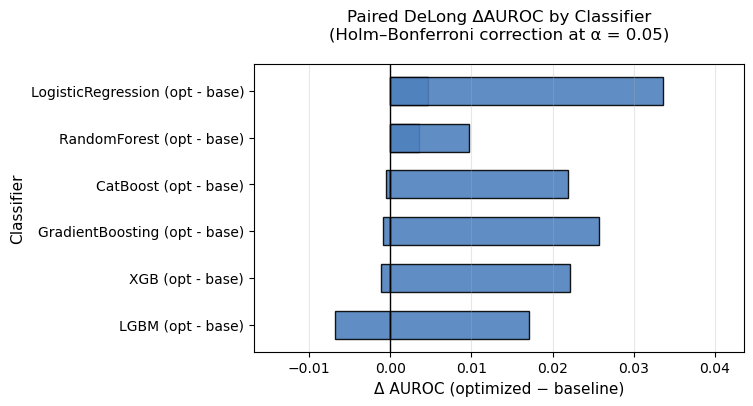

✅ Saved clean ΔAUROC DeLong plot (no labels, no 'best') → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delta_auroc_delong_bar.png


In [26]:
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------
# Prepare data (drop 'best')
# --------------------------------------------------
sub = df_delong.copy()
sub["Classifier"] = sub["model_a"].str.split("::").str[1]
sub = sub[sub["Classifier"].str.lower() != "best"].reset_index(drop=True)
sub["pair"] = sub["Classifier"] + " (opt - base)"
sub_sorted = sub.sort_values("delta", ascending=True)

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.barh(
    sub_sorted["pair"],
    sub_sorted["delta"],
    color="#4F81BD",
    alpha=0.9,
    edgecolor="black",
    height=0.6,
)

# Expand x-axis limits slightly for visual balance
delta_min, delta_max = sub_sorted["delta"].min(), sub_sorted["delta"].max()
pad = max(0.01, 0.15 * (delta_max - delta_min))
ax.set_xlim(delta_min - pad, delta_max + pad)

# --------------------------------------------------
# Styling and labels
# --------------------------------------------------
ax.axvline(0, color="black", lw=1)
ax.set_xlabel("Δ AUROC (optimized − baseline)", fontsize=11)
ax.set_ylabel("Classifier", fontsize=11)
ax.set_title(
    "Paired DeLong ΔAUROC by Classifier\n(Holm–Bonferroni correction at α = 0.05)",
    fontsize=12, pad=18
)
ax.grid(axis="x", alpha=0.3)
plt.subplots_adjust(left=0.28, right=0.98, top=0.9, bottom=0.18)

# --------------------------------------------------
# Save + display
# --------------------------------------------------
plot_path = Path(out_dir) / "delta_auroc_delong_bar.png"
fig.savefig(plot_path, dpi=400, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"✅ Saved clean ΔAUROC DeLong plot (no labels, no 'best') → {plot_path}")


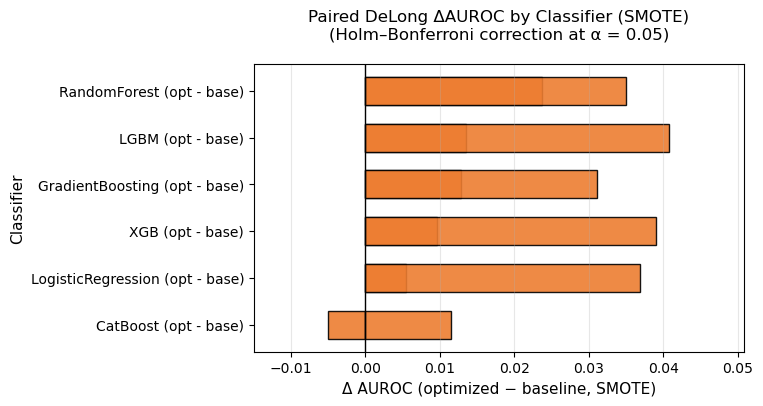

✅ Saved clean ΔAUROC DeLong SMOTE plot (no labels, no 'best') → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delta_auroc_delong_bar_smote.png


In [27]:
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------
# Prepare SMOTE data (drop 'best')
# --------------------------------------------------
sub_smote = df_delong_smote.copy()
sub_smote["Classifier"] = sub_smote["model_a"].str.split("::").str[1]
sub_smote = sub_smote[sub_smote["Classifier"].str.lower() != "best"].reset_index(drop=True)
sub_smote["pair"] = sub_smote["Classifier"] + " (opt - base)"
sub_sorted_smote = sub_smote.sort_values("delta", ascending=True)

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.barh(
    sub_sorted_smote["pair"],
    sub_sorted_smote["delta"],
    color="#ED7D31",        # orange for SMOTE contrast
    alpha=0.9,
    edgecolor="black",
    height=0.6,
)

# Expand x-axis limits slightly for visual balance
delta_min, delta_max = sub_sorted_smote["delta"].min(), sub_sorted_smote["delta"].max()
pad = max(0.01, 0.15 * (delta_max - delta_min))
ax.set_xlim(delta_min - pad, delta_max + pad)

# --------------------------------------------------
# Styling and labels
# --------------------------------------------------
ax.axvline(0, color="black", lw=1)
ax.set_xlabel("Δ AUROC (optimized − baseline, SMOTE)", fontsize=11)
ax.set_ylabel("Classifier", fontsize=11)
ax.set_title(
    "Paired DeLong ΔAUROC by Classifier (SMOTE)\n(Holm–Bonferroni correction at α = 0.05)",
    fontsize=12, pad=18
)
ax.grid(axis="x", alpha=0.3)
plt.subplots_adjust(left=0.28, right=0.98, top=0.9, bottom=0.18)

# --------------------------------------------------
# Save + display
# --------------------------------------------------
plot_path_smote = Path(out_dir_smote) / "delta_auroc_delong_bar_smote.png"
fig.savefig(plot_path_smote, dpi=400, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"✅ Saved clean ΔAUROC DeLong SMOTE plot (no labels, no 'best') → {plot_path_smote}")


# 9 Non-SMOTE vs SMOTE Delta AUROC Comparison with Holm-Bonferroni

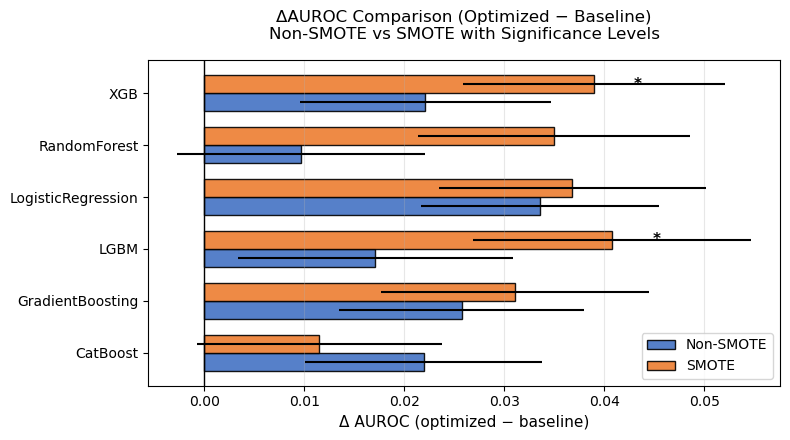

✅ Thesis-ready ΔAUROC comparison with significance stars saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delta_auroc_delong_side_by_side_sig.png


In [36]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# --------------------------------------------------
# Merge DeLong + p_holm from both variants
# --------------------------------------------------
df_non = df_summary_display.copy()
df_non["Variant"] = "Non-SMOTE"
df_sm = df_summary_display_smote.copy()
df_sm["Variant"] = "SMOTE"

# Combine and clean
df_both = pd.concat([df_non, df_sm], ignore_index=True)

mask = df_both["Comparison"].str.contains("opt vs original", regex=False)
df_both = df_both[mask].copy()

df_both["Classifier"] = df_both["Classifier"]
df_both = df_both[df_both["Classifier"].str.lower() != "best"].reset_index(drop=True)

# Aggregate ΔAUROC, SE, and Holm-corrected p-values
df_plot = (
    df_both.groupby(["Classifier", "Variant"], as_index=False)
    .agg({
        "ΔAUROC (opt - baseline)": "mean",
        "SE (Δ)": "mean",
        "p_holm": "min"  # conservative significance per classifier-variant
    })
)

# Assign significance stars
def star(p):
    if p < 0.001: return "***"
    elif p < 0.01: return "**"
    elif p < 0.05: return "*"
    else: return ""

df_plot["sig"] = df_plot["p_holm"].apply(star)

# --------------------------------------------------
# Plot configuration
# --------------------------------------------------
classifiers = df_plot["Classifier"].unique()
x = np.arange(len(classifiers))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4.5))

# Non-SMOTE bars
bars1 = ax.barh(
    x - width/2,
    df_plot[df_plot["Variant"] == "Non-SMOTE"]["ΔAUROC (opt - baseline)"],
    xerr=df_plot[df_plot["Variant"] == "Non-SMOTE"]["SE (Δ)"],
    height=width,
    label="Non-SMOTE",
    color="#4472C4",
    alpha=0.9,
    edgecolor="black",
)

# SMOTE bars
bars2 = ax.barh(
    x + width/2,
    df_plot[df_plot["Variant"] == "SMOTE"]["ΔAUROC (opt - baseline)"],
    xerr=df_plot[df_plot["Variant"] == "SMOTE"]["SE (Δ)"],
    height=width,
    label="SMOTE",
    color="#ED7D31",
    alpha=0.9,
    edgecolor="black",
)

# --------------------------------------------------
# Add significance stars
# --------------------------------------------------
for i, clf in enumerate(classifiers):
    for variant, offset in zip(["Non-SMOTE", "SMOTE"], [-width/2, +width/2]):
        val = df_plot.query("Classifier == @clf and Variant == @variant")["ΔAUROC (opt - baseline)"].values[0]
        sig = df_plot.query("Classifier == @clf and Variant == @variant")["sig"].values[0]
        if sig:
            ax.text(
                val + (0.004 if val >= 0 else -0.004),
                i + offset,
                sig,
                va="center",
                ha="left" if val >= 0 else "right",
                fontsize=11,
                fontweight="bold",
                color="black"
            )

# --------------------------------------------------
# Axes and labels
# --------------------------------------------------
ax.axvline(0, color="black", lw=1)
ax.set_yticks(x)
ax.set_yticklabels(classifiers, fontsize=10)
ax.set_xlabel("Δ AUROC (optimized − baseline)", fontsize=11)
ax.set_title(
    "ΔAUROC Comparison (Optimized − Baseline)\nNon-SMOTE vs SMOTE with Significance Levels",
    fontsize=12, pad=15
)
ax.legend(loc="lower right", frameon=True)
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()

# --------------------------------------------------
# Save and show
# --------------------------------------------------
fig_dir = Path(resolve_path(f"results/stat_tests/{today}"))
fig_dir.mkdir(parents=True, exist_ok=True)
plot_path_sig = fig_dir / "delta_auroc_delong_side_by_side_sig.png"

plt.savefig(plot_path_sig, dpi=400, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"✅ Thesis-ready ΔAUROC comparison with significance stars saved → {plot_path_sig}")


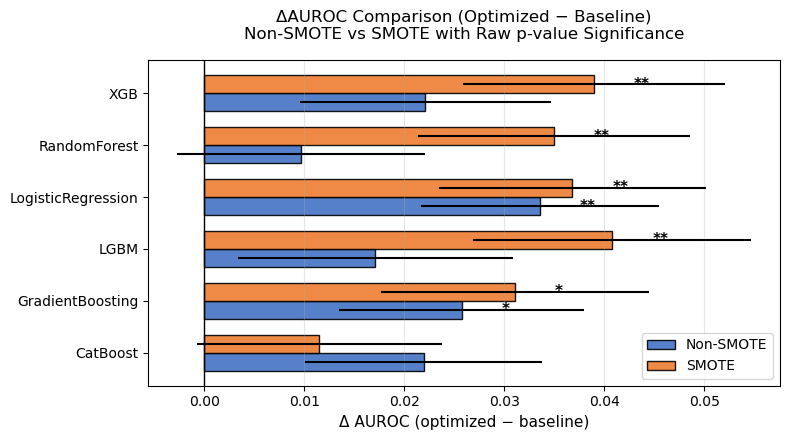

✅ ΔAUROC comparison with RAW p-value significance stars saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delta_auroc_delong_side_by_side_rawp.png


In [41]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# --------------------------------------------------
# Combine both variants with RAW p-values
# --------------------------------------------------
df_non_raw = df_summary_display.copy()
df_non_raw["Variant"] = "Non-SMOTE"

df_sm_raw = df_summary_display_smote.copy()
df_sm_raw["Variant"] = "SMOTE"

df_both_raw = pd.concat([df_non_raw, df_sm_raw], ignore_index=True)

# Keep only opt vs original comparisons (non-SMOTE + SMOTE)
mask_raw = df_both_raw["Comparison"].str.contains("opt vs original", regex=False)
df_both_raw = df_both_raw[mask_raw].copy()

# Drop any "best" aggregate rows
df_both_raw = df_both_raw[df_both_raw["Classifier"].str.lower() != "best"].reset_index(drop=True)

# Aggregate ΔAUROC, SE, and RAW p-values
df_plot_raw = (
    df_both_raw.groupby(["Classifier", "Variant"], as_index=False)
    .agg({
        "ΔAUROC (opt - baseline)": "mean",
        "SE (Δ)": "mean",
        "p (DeLong)": "min"   # conservative per classifier-variant
    })
)

# Assign significance stars using UNADJUSTED p-values
def star_raw(p):
    if p < 0.001: return "***"
    elif p < 0.01: return "**"
    elif p < 0.05: return "*"
    else: return ""

df_plot_raw["sig"] = df_plot_raw["p (DeLong)"].apply(star_raw)

# --------------------------------------------------
# Plot configuration
# --------------------------------------------------
classifiers = df_plot_raw["Classifier"].unique()
x = np.arange(len(classifiers))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 4.5))

# Non-SMOTE bars
non_mask = df_plot_raw["Variant"] == "Non-SMOTE"
sm_mask  = df_plot_raw["Variant"] == "SMOTE"

bars1 = ax.barh(
    x - width/2,
    df_plot_raw.loc[non_mask, "ΔAUROC (opt - baseline)"],
    xerr=df_plot_raw.loc[non_mask, "SE (Δ)"],
    height=width,
    label="Non-SMOTE",
    color="#4472C4",
    alpha=0.9,
    edgecolor="black",
)

# SMOTE bars
bars2 = ax.barh(
    x + width/2,
    df_plot_raw.loc[sm_mask, "ΔAUROC (opt - baseline)"],
    xerr=df_plot_raw.loc[sm_mask, "SE (Δ)"],
    height=width,
    label="SMOTE",
    color="#ED7D31",
    alpha=0.9,
    edgecolor="black",
)

# --------------------------------------------------
# Add significance stars (RAW p-values)
# --------------------------------------------------
for i, clf in enumerate(classifiers):
    for variant, offset in zip(["Non-SMOTE", "SMOTE"], [-width/2, +width/2]):
        row = df_plot_raw.query("Classifier == @clf and Variant == @variant")
        val = row["ΔAUROC (opt - baseline)"].values[0]
        sig = row["sig"].values[0]
        if sig:
            ax.text(
                val + (0.004 if val >= 0 else -0.004),
                i + offset,
                sig,
                va="center",
                ha="left" if val >= 0 else "right",
                fontsize=11,
                fontweight="bold",
                color="black"
            )

# --------------------------------------------------
# Axes and labels
# --------------------------------------------------
ax.axvline(0, color="black", lw=1)
ax.set_yticks(x)
ax.set_yticklabels(classifiers, fontsize=10)
ax.set_xlabel("Δ AUROC (optimized − baseline)", fontsize=11)
ax.set_title(
    "ΔAUROC Comparison (Optimized − Baseline)\nNon-SMOTE vs SMOTE with Raw p-value Significance",
    fontsize=12, pad=15
)
ax.legend(loc="lower right", frameon=True)
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()

# --------------------------------------------------
# Save and display
# --------------------------------------------------
fig_dir = Path(resolve_path(f"results/stat_tests/{today}"))
fig_dir.mkdir(parents=True, exist_ok=True)
plot_path_raw = fig_dir / "delta_auroc_delong_side_by_side_rawp.png"

plt.savefig(plot_path_raw, dpi=400, bbox_inches="tight")
plt.show()
plt.close(fig)

print(f"✅ ΔAUROC comparison with RAW p-value significance stars saved → {plot_path_raw}")


## 10 MLflow Logging

In [ ]:
import mlflow
from pathlib import Path

# --------------------------------------------------
# Setup MLflow experiment
# --------------------------------------------------
tracking_dir = Path(resolve_path("mlflow_tracking")).absolute()
mlflow.set_tracking_uri(tracking_dir.as_uri())
mlflow.set_experiment("Thesis_ModelTraining")

# --------------------------------------------------
# Log all statistical testing artifacts (Non-SMOTE + SMOTE)
# --------------------------------------------------
with mlflow.start_run(run_name="Task11_StatisticalTesting", nested=True):
    mlflow.set_tag("task", "Task_11_StatisticalTesting")
    mlflow.set_tag("module", "statistical_tests")
    mlflow.set_tag("description", "Paired DeLong tests and bootstrap CIs for optimized vs baseline classifiers")

    # ==================================================
    # 🧩 Non-SMOTE Artifacts
    # ==================================================
    print("📦 Logging Non-SMOTE statistical testing outputs...")
    mlflow.set_tag("variant", "non_smote")

    for f in [
        "delong_summary.csv",
        "bootstrap_auc_ci.csv",
        "stat_tests_summary_display.csv",
        "stat_tests_summary_full.csv",
        "delong_results_table.tex",
        "bootstrap_auc_table.tex",
        "delong_results_multirow.tex",
        "bootstrap_auc_multirow.tex",
        # Plots
        "delta_auroc_delong_bar.png",
        "delta_auroc_delong_side_by_side_sig.png",   # Holm-Bonferroni corrected
        "delta_auroc_delong_side_by_side_rawp.png",  # Raw p-values
    ]:
        file_path = out_dir / f
        if file_path.exists():
            mlflow.log_artifact(str(file_path), artifact_path="stat_tests/non_smote")
            # Tag artifact type
            if f.endswith(".csv"):
                mlflow.set_tag("artifact_type", "summary")
            elif f.endswith(".tex"):
                mlflow.set_tag("artifact_type", "latex")
            elif f.endswith(".png"):
                mlflow.set_tag("artifact_type", "plot")
                if "rawp" in f:
                    mlflow.set_tag("p_type", "raw")
                elif "sig" in f:
                    mlflow.set_tag("p_type", "holm")
        else:
            print(f"⚠️ Missing Non-SMOTE artifact → {file_path}")

    # Metrics for Non-SMOTE
    if "ΔAUROC (opt - baseline)" in df_summary_full.columns:
        mlflow.log_metric(
            "mean_delta_auroc_non_smote",
            float(df_summary_full["ΔAUROC (opt - baseline)"].mean())
        )
        mlflow.log_metric(
            "max_delta_auroc_non_smote",
            float(df_summary_full["ΔAUROC (opt - baseline)"].max())
        )

    # ==================================================
    # 🧩 SMOTE Artifacts
    # ==================================================
    print("\n📦 Logging SMOTE statistical testing outputs...")
    mlflow.set_tag("variant", "smote")
    
    for f in [
        "delong_summary_smote.csv",
        "bootstrap_auc_ci_smote.csv",
        "stat_tests_summary_display_smote.csv",
        "stat_tests_summary_full_smote.csv",
        "delong_results_table_smote.tex",
        "bootstrap_auc_table_smote.tex",
        "delong_results_multirow_smote.tex",
        "bootstrap_auc_multirow_smote.tex",
        # Plots (only bar plot retained for SMOTE)
        "delta_auroc_delong_bar_smote.png",
    ]:
        file_path = out_dir_smote / f
        if file_path.exists():
            mlflow.log_artifact(str(file_path), artifact_path="stat_tests/smote")
    
            # Tag artifact type
            if f.endswith(".csv"):
                mlflow.set_tag("artifact_type", "summary")
            elif f.endswith(".tex"):
                mlflow.set_tag("artifact_type", "latex")
            elif f.endswith(".png"):
                mlflow.set_tag("artifact_type", "plot")
                if f == "delta_auroc_delong_bar_smote.png":
                    mlflow.set_tag("plot_variant", "simple_bar")
    
        else:
            print(f"⚠️ Missing SMOTE artifact → {file_path}")



    # Metrics for SMOTE
    if "ΔAUROC (opt - baseline)" in df_summary_full_smote.columns:
        mlflow.log_metric(
            "mean_delta_auroc_smote",
            float(df_summary_full_smote["ΔAUROC (opt - baseline)"].mean())
        )
        mlflow.log_metric(
            "max_delta_auroc_smote",
            float(df_summary_full_smote["ΔAUROC (opt - baseline)"].max())
        )

print("✅ Logged all Task 11 artifacts and metrics (Non-SMOTE + SMOTE, raw + Holm plots) under experiment 'Thesis_ModelTraining'.")


## F2 Sensitivity Analysis For SMOTE vs Non-SMOTE

In [ ]:
loaded_models_baseline

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from src.evaluation import get_scores
from src.stat_tests import (
    f2_at_threshold,
    bootstrap_delta_f2,
    mcnemar_recall_test,
    f2_curve
)

# ============================================================
# 1) Use optimized W2V holdout set (the only compatible one)
# ============================================================
X_holdout = X_tests["w2v_optimized_radiology"]
y_holdout = y_tests["w2v_optimized_radiology"]

print("Holdout shapes (optimized W2V):")
print("  X_holdout:", X_holdout.shape)
print("  y_holdout:", y_holdout.shape)

# ============================================================
# 2) Extract only optimized-W2V baseline/SMOTE models
# ============================================================
baseline_opt = {
    k: v for k, v in loaded_models_baseline.items()
    if k.startswith("w2v_optimized_radiology_")
}

smote_opt = {
    k: v for k, v in loaded_models_smote.items()
    if k.startswith("w2v_optimized_radiology_")
}

print("\nFiltered baseline models:", list(baseline_opt.keys()))
print("Filtered SMOTE models:   ", list(smote_opt.keys()))

# ============================================================
# 3) Normalize classifier names
# ============================================================
def extract_clf_name(key):
    """
    w2v_optimized_radiology_XGB                -> XGB
    w2v_optimized_radiology_XGB_smote         -> XGB
    """
    parts = key.split("_")
    # last meaningful token before optional "smote"
    if parts[-1] == "smote":
        return parts[-2]
    return parts[-1]

# ============================================================
# 4) Get probabilities (only optimized track)
# ============================================================
probs_non_smote = {}
probs_smote = {}

print("\n--- Non-SMOTE (optimized W2V) ---")
for key, model in baseline_opt.items():
    clf = extract_clf_name(key)
    try:
        probs_non_smote[clf] = get_scores(model, X_holdout)
        print(f"[keep] {clf}")
    except Exception as e:
        print(f"[skip] {clf}: {e}")

print("\n--- SMOTE (optimized W2V) ---")
for key, model in smote_opt.items():
    clf = extract_clf_name(key)
    try:
        probs_smote[clf] = get_scores(model, X_holdout)
        print(f"[keep] {clf}")
    except Exception as e:
        print(f"[skip] {clf}: {e}")

# ============================================================
# 5) Final matched classifier list
# ============================================================
classifiers = sorted(set(probs_non_smote.keys()) & set(probs_smote.keys()))

print("\nIncluded classifiers (matched SMOTE vs non-SMOTE):")
print(classifiers)


In [ ]:
# ============================================================
# ΔF2, Bootstrap CI, McNemar Recall Test, Holm–Bonferroni
# ============================================================
beta = 2.0
thr = 0.5

records = []

for clf in classifiers:
    p_non = np.asarray(probs_non_smote[clf])
    p_sm  = np.asarray(probs_smote[clf])

    # -----------------------------------
    # F2 at threshold 0.5 for both tracks
    # -----------------------------------
    f2_non = f2_at_threshold(y_holdout, p_non, thr=thr, beta=beta)
    f2_sm  = f2_at_threshold(y_holdout, p_sm,  thr=thr, beta=beta)

    # -----------------------------------
    # Paired bootstrap ΔF2
    # -----------------------------------
    boot = bootstrap_delta_f2(
        y_holdout, p_non, p_sm,
        n_boot=2000, thr=thr, beta=beta, random_state=42
    )

    # -----------------------------------
    # McNemar test on recall among positives
    # -----------------------------------
    stat_mc, p_mc = mcnemar_recall_test(y_holdout, p_non, p_sm, thr=thr)

    records.append({
        "Classifier": clf,
        "F2_non_SMOTE": f2_non,
        "F2_SMOTE": f2_sm,
        "ΔF2 (SMOTE - non-SMOTE)": f2_sm - f2_non,
        "ΔF2_boot_mean": boot["delta_f2"],
        "CI_low": boot["ci_low"],
        "CI_high": boot["ci_high"],
        "McNemar_chi2_recall": stat_mc,
        "McNemar_p_recall": p_mc,
    })

df_delta_f2 = pd.DataFrame(records)

# ------------------------------------------------------------
# Holm–Bonferroni correction for McNemar p-values
# ------------------------------------------------------------
raw_p = df_delta_f2["McNemar_p_recall"].values.copy()
m = len(raw_p)

order = np.argsort(raw_p)
sorted_p = raw_p[order]

adj_sorted = np.zeros_like(sorted_p)
prev = 0
for k, p in enumerate(sorted_p, start=1):
    p_h = min(p * (m - k + 1), 1.0)
    adj_sorted[k-1] = max(p_h, prev)
    prev = adj_sorted[k-1]

# Unsort back
p_holm = np.zeros_like(raw_p)
p_holm[order] = adj_sorted

df_delta_f2["McNemar_p_holm"] = p_holm

# ------------------------------------------------------------
# Final sorted output
# ------------------------------------------------------------
df_delta_f2 = df_delta_f2.sort_values("ΔF2 (SMOTE - non-SMOTE)", ascending=False).reset_index(drop=True)

display(df_delta_f2)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ------------------------------------------------------------
# Prepare sorted dataset
# ------------------------------------------------------------
df_plot = df_delta_f2.copy()
df_plot = df_plot.sort_values("ΔF2 (SMOTE - non-SMOTE)", ascending=True)

pairs = df_plot["Classifier"]
delta = df_plot["ΔF2 (SMOTE - non-SMOTE)"]
p_holm = df_plot["McNemar_p_holm"]

# Significance markers based on Holm–Bonferroni
sig_holm = (p_holm < 0.05)

# ------------------------------------------------------------
# Create Holm-only figure
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 5))

ax.barh(pairs, delta, color="#C0504D", edgecolor="black")

# Add ΔF₂ labels + significance stars
for i, (d, sig) in enumerate(zip(delta, sig_holm)):
    mark = "*" if sig else ""
    ax.text(
        d + np.sign(d)*0.005,
        i,
        f"{d:+.3f}{mark}",
        va="center",
        ha="left" if d >= 0 else "right"
    )

# Reference line at zero
ax.axvline(0, color="black", lw=1)

# Labels and styling
ax.set_title("ΔF₂ (SMOTE − non-SMOTE)\nHolm–Bonferroni–adjusted significance", fontsize=12)
ax.set_xlabel("ΔF₂")
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()

# ------------------------------------------------------------
# Save figure
# ------------------------------------------------------------
out_dir = Path(resolve_path("results/figures/stat_tests"))
out_dir.mkdir(parents=True, exist_ok=True)

plot_path = out_dir / "delta_f2_holm_only.png"
fig.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved Holm-only ΔF₂ plot → {plot_path}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
# Prepare data
# ------------------------------------------------------------
df_plot = df_delta_f2.copy()

classifiers = df_plot["Classifier"]

f2_non = df_plot["F2_non_SMOTE"].values
f2_sm  = df_plot["F2_SMOTE"].values

x = np.arange(len(classifiers))
width = 0.35

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

bars1 = ax.bar(x - width/2, f2_non, width,
               label="Non-SMOTE", color="#4F81BD", edgecolor="black")

bars2 = ax.bar(x + width/2, f2_sm, width,
               label="SMOTE", color="#C0504D", edgecolor="black")

# Labels
ax.set_xticks(x)
ax.set_xticklabels(classifiers, rotation=45, ha="right")
ax.set_ylabel("F₂ score (threshold = 0.5)")
ax.set_title("Sensitivity-Weighted F₂ Scores\nSMOTE vs Non-SMOTE by Classifier")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()

# ------------------------------------------------------------
# Save
# ------------------------------------------------------------
out_dir = Path(resolve_path("results/figures/stat_tests"))
out_dir.mkdir(parents=True, exist_ok=True)

plot_path = out_dir / "f2_smote_vs_non_smote_bar.png"
fig.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Saved → {plot_path}")


In [ ]:
from pathlib import Path
from datetime import datetime

today = datetime.now().strftime("%Y%m%d")
out_dir = Path(resolve_path(f"results/stat_tests/{today}"))
out_dir.mkdir(parents=True, exist_ok=True)

# ============================================================
# Prepare LaTeX export DataFrame
# ============================================================
df_latex = df_delta_f2.copy()

df_latex = df_latex.rename(columns={
    "Classifier": "Classifier",
    "F2_non_SMOTE": "F$_{2}$ (non-SMOTE)",
    "F2_SMOTE": "F$_{2}$ (SMOTE)",
    "ΔF2 (SMOTE - non-SMOTE)": "$\\Delta$F$_{2}$",
    "ΔF2_boot_mean": "$\\Delta$F$_{2}$ Mean",
    "CI_low": "CI Low",
    "CI_high": "CI High",
    "McNemar_chi2_recall": "McNemar $\\chi^{2}$",
    "McNemar_p_recall": "p raw",
    "McNemar_p_holm": "p holm"
})

# Format numeric fields
for col in ["F$_{2}$ (non-SMOTE)", "F$_{2}$ (SMOTE)", "$\\Delta$F$_{2}$",
            "$\\Delta$F$_{2}$ Mean", "CI Low", "CI High"]:
    df_latex[col] = df_latex[col].map("{:.3f}".format)

df_latex["McNemar $\\chi^{2}$"] = df_latex["McNemar $\\chi^{2}$"].map("{:.2f}".format)
df_latex["p raw"]  = df_latex["p raw"].map("{:.3g}".format)
df_latex["p holm"] = df_latex["p holm"].map("{:.3g}".format)

# ============================================================
# Generate inner table code (tabular only)
# ============================================================
inner_table = df_latex.to_latex(
    index=False,
    escape=False,           # Keep math formatting
    column_format="l r r r r r r r r"
)

# Strip outer environment (Pandas wraps with \begin{tabular} ... \end{tabular})
inner_lines = inner_table.splitlines()
inner_tabular = "\n".join(inner_lines[1:-1])   # remove \begin and \end

# ============================================================
# Wrap in resizebox + full table environment
# ============================================================
latex_full = rf"""
\begin{{table}}[H]
\centering
\caption{{ΔF$_2$ performance comparison for SMOTE vs non-SMOTE on the holdout set, including bootstrap confidence intervals and Holm-adjusted McNemar p-values.}}
\label{{tab:delta_f2}}
\resizebox{{\textwidth}}{{!}}{{%
\begin{{tabular}}{{l r r r r r r r r}}
\toprule
{inner_tabular}
\bottomrule
\end{{tabular}}
}}
\end{{table}}
"""

# ============================================================
# Save the LaTeX file
# ============================================================
latex_path = out_dir / "delta_f2_table.tex"
latex_path.write_text(latex_full, encoding="utf-8")

print(f"📄 LaTeX ΔF₂ table (resized) exported → {latex_path}")


## Best Model Comparisons

In [42]:
from sklearn.metrics import roc_auc_score

# =========================================
# Helper: pick best clf by AUROC
# =========================================
def pick_best_by_auc(probs_dict, y_true):
    """Return (best_clf_name, best_auc, full_auc_dict)."""
    aucs = {
        clf: roc_auc_score(y_true, probs)
        for clf, probs in probs_dict.items()
    }
    best_clf = max(aucs, key=aucs.get)
    return best_clf, aucs[best_clf], aucs

best_records = []
best_models = {
    "Non-SMOTE": {},
    "SMOTE": {},
}

# ===============================
# Non-SMOTE variants
# ===============================
for variant_label, probs_dict in [
    ("original",          probs_original),
    ("w2v_radiology",     probs_w2v),
    ("w2v_optimized_radiology", probs_w2v_opt),
]:
    best_clf, best_auc, aucs_all = pick_best_by_auc(probs_dict, y_true)
    best_models["Non-SMOTE"][variant_label] = {
        "clf": best_clf,
        "auc": best_auc,
        "probs": probs_dict[best_clf],
        "all_aucs": aucs_all,
    }
    best_records.append({
        "Resampling": "Non-SMOTE",
        "Variant": variant_label,
        "Classifier": best_clf,
        "AUROC": best_auc,
    })

# ===============================
# SMOTE variants
# ===============================
for variant_label, probs_dict in [
    ("original",          probs_original_smote),
    ("w2v_radiology",     probs_w2v_smote),
    ("w2v_optimized_radiology", probs_w2v_opt_smote),
]:
    best_clf, best_auc, aucs_all = pick_best_by_auc(probs_dict, y_true)
    best_models["SMOTE"][variant_label] = {
        "clf": best_clf,
        "auc": best_auc,
        "probs": probs_dict[best_clf],
        "all_aucs": aucs_all,
    }
    best_records.append({
        "Resampling": "SMOTE",
        "Variant": variant_label,
        "Classifier": best_clf,
        "AUROC": best_auc,
    })

best_df = pd.DataFrame(best_records)
display(best_df.sort_values(["Resampling", "Variant"]))

print("\n✅ Selected best classifier per variant and resampling scheme.")
print(best_df)


,Resampling,Variant,Classifier,AUROC
0,Non-SMOTE,original,CatBoost,0.734284
2,Non-SMOTE,w2v_optimized_radiology,LogisticRegression,0.756984
1,Non-SMOTE,w2v_radiology,CatBoost,0.756803
3,SMOTE,original,CatBoost,0.724805
5,SMOTE,w2v_optimized_radiology,LogisticRegression,0.753001
4,SMOTE,w2v_radiology,LogisticRegression,0.747577



✅ Selected best classifier per variant and resampling scheme.
  Resampling                  Variant          Classifier     AUROC
0  Non-SMOTE                 original            CatBoost  0.734284
1  Non-SMOTE            w2v_radiology            CatBoost  0.756803
2  Non-SMOTE  w2v_optimized_radiology  LogisticRegression  0.756984
3      SMOTE                 original            CatBoost  0.724805
4      SMOTE            w2v_radiology  LogisticRegression  0.747577
5      SMOTE  w2v_optimized_radiology  LogisticRegression  0.753001


In [43]:
# =========================================
# DeLong – best NON-SMOTE models
# =========================================

# Unpack best NON-SMOTE models
orig_best_ns = best_models["Non-SMOTE"]["original"]
w2v_best_ns  = best_models["Non-SMOTE"]["w2v_radiology"]
opt_best_ns  = best_models["Non-SMOTE"]["w2v_optimized_radiology"]

model_probs_best_ns = {
    f"orig::{orig_best_ns['clf']}": orig_best_ns["probs"],
    f"w2v::{w2v_best_ns['clf']}":   w2v_best_ns["probs"],
    f"opt::{opt_best_ns['clf']}":   opt_best_ns["probs"],
}

pairs_best_ns = [
    (f"opt::{opt_best_ns['clf']}",  f"orig::{orig_best_ns['clf']}"),
    (f"opt::{opt_best_ns['clf']}",  f"w2v::{w2v_best_ns['clf']}"),
    (f"w2v::{w2v_best_ns['clf']}",  f"orig::{orig_best_ns['clf']}"),
]

df_delong_best_ns = compare_aurocs(
    model_probs_best_ns,
    y_true,
    pairs_best_ns,
    method="delong",
)

# Holm–Bonferroni on these best NON-SMOTE comparisons
from statsmodels.stats.multitest import multipletests

df_delong_best_ns["p_holm"] = np.nan
mask_valid = df_delong_best_ns["p_value"].notna()
df_delong_best_ns.loc[mask_valid, "p_holm"] = multipletests(
    df_delong_best_ns.loc[mask_valid, "p_value"],
    method="holm"
)[1]
df_delong_best_ns["significant (0.05, Holm)"] = df_delong_best_ns["p_holm"] < 0.05
df_delong_best_ns["Resampling"] = "Non-SMOTE"

display(df_delong_best_ns)
print("✅ DeLong + Holm–Bonferroni for best NON-SMOTE models complete.")


,model_a,model_b,auc_a,auc_b,delta,se_delta,z,p_value,ci_low,ci_high,method,p_holm,"significant (0.05, Holm)",Resampling
0,opt::LogisticRegression,orig::CatBoost,0.756984,0.734284,0.022700,0.013869,1.636704,0.101692,NaN,NaN,delong,0.203385,False,Non-SMOTE
1,opt::LogisticRegression,w2v::CatBoost,0.756984,0.756803,0.000181,0.012302,0.014738,0.988241,NaN,NaN,delong,0.988241,False,Non-SMOTE
2,w2v::CatBoost,orig::CatBoost,0.756803,0.734284,0.022519,0.010976,2.051699,0.040199,NaN,NaN,delong,0.120597,False,Non-SMOTE


✅ DeLong + Holm–Bonferroni for best NON-SMOTE models complete.


In [44]:
# =========================================
# DeLong – best SMOTE models
# =========================================

orig_best_s = best_models["SMOTE"]["original"]
w2v_best_s  = best_models["SMOTE"]["w2v_radiology"]
opt_best_s  = best_models["SMOTE"]["w2v_optimized_radiology"]

model_probs_best_s = {
    f"orig::{orig_best_s['clf']}": orig_best_s["probs"],
    f"w2v::{w2v_best_s['clf']}":   w2v_best_s["probs"],
    f"opt::{opt_best_s['clf']}":   opt_best_s["probs"],
}

pairs_best_s = [
    (f"opt::{opt_best_s['clf']}",  f"orig::{orig_best_s['clf']}"),
    (f"opt::{opt_best_s['clf']}",  f"w2v::{w2v_best_s['clf']}"),
    (f"w2v::{w2v_best_s['clf']}",  f"orig::{orig_best_s['clf']}"),
]

df_delong_best_s = compare_aurocs(
    model_probs_best_s,
    y_true,
    pairs_best_s,
    method="delong",
)

df_delong_best_s["p_holm"] = np.nan
mask_valid = df_delong_best_s["p_value"].notna()
df_delong_best_s.loc[mask_valid, "p_holm"] = multipletests(
    df_delong_best_s.loc[mask_valid, "p_value"],
    method="holm"
)[1]
df_delong_best_s["significant (0.05, Holm)"] = df_delong_best_s["p_holm"] < 0.05
df_delong_best_s["Resampling"] = "SMOTE"

display(df_delong_best_s)
print("✅ DeLong + Holm–Bonferroni for best SMOTE models complete.")

# (optional) combine both into a single table
df_delong_best_all = pd.concat([df_delong_best_ns, df_delong_best_s], ignore_index=True)
display(df_delong_best_all)


,model_a,model_b,auc_a,auc_b,delta,se_delta,z,p_value,ci_low,ci_high,method,p_holm,"significant (0.05, Holm)",Resampling
0,opt::LogisticRegression,orig::CatBoost,0.753001,0.724805,0.028196,0.014758,1.910536,0.056064,NaN,NaN,delong,0.168193,False,SMOTE
1,opt::LogisticRegression,w2v::LogisticRegression,0.753001,0.747577,0.005424,0.008421,0.644039,0.519550,NaN,NaN,delong,0.519550,False,SMOTE
2,w2v::LogisticRegression,orig::CatBoost,0.747577,0.724805,0.022772,0.014250,1.598096,0.110022,NaN,NaN,delong,0.220043,False,SMOTE


✅ DeLong + Holm–Bonferroni for best SMOTE models complete.


,model_a,model_b,auc_a,auc_b,delta,se_delta,z,p_value,ci_low,ci_high,method,p_holm,"significant (0.05, Holm)",Resampling
0,opt::LogisticRegression,orig::CatBoost,0.756984,0.734284,0.022700,0.013869,1.636704,0.101692,NaN,NaN,delong,0.203385,False,Non-SMOTE
1,opt::LogisticRegression,w2v::CatBoost,0.756984,0.756803,0.000181,0.012302,0.014738,0.988241,NaN,NaN,delong,0.988241,False,Non-SMOTE
2,w2v::CatBoost,orig::CatBoost,0.756803,0.734284,0.022519,0.010976,2.051699,0.040199,NaN,NaN,delong,0.120597,False,Non-SMOTE
3,opt::LogisticRegression,orig::CatBoost,0.753001,0.724805,0.028196,0.014758,1.910536,0.056064,NaN,NaN,delong,0.168193,False,SMOTE
4,opt::LogisticRegression,w2v::LogisticRegression,0.753001,0.747577,0.005424,0.008421,0.644039,0.519550,NaN,NaN,delong,0.519550,False,SMOTE
5,w2v::LogisticRegression,orig::CatBoost,0.747577,0.724805,0.022772,0.014250,1.598096,0.110022,NaN,NaN,delong,0.220043,False,SMOTE


In [45]:
# =========================================
# Bootstrap CIs for best models (all 6)
# =========================================

records_ci_best = []

for resampling, subset in best_models.items():
    for variant_label, info in subset.items():
        clf_name = info["clf"]
        probs = info["probs"]
        ci = bootstrap_auc_ci(
            y_true,
            probs,
            n_boot=2000,
            alpha=0.95,
            stratified=True,
        )
        records_ci_best.append({
            "Resampling": resampling,
            "Variant": variant_label,
            "Classifier": clf_name,
            "AUROC": ci["auc"],
            "SE": ci["se"],
            "CI_low": ci["ci_low"],
            "CI_high": ci["ci_high"],
        })

df_ci_best = pd.DataFrame(records_ci_best)
display(df_ci_best.sort_values(["Resampling", "Variant"]))
print("✅ Bootstrapped stratified 95% CIs computed for best models (Non-SMOTE + SMOTE).")


,Resampling,Variant,Classifier,AUROC,SE,CI_low,CI_high
0,Non-SMOTE,original,CatBoost,0.734284,0.016911,0.700052,0.767640
2,Non-SMOTE,w2v_optimized_radiology,LogisticRegression,0.756984,0.016291,0.724849,0.789092
1,Non-SMOTE,w2v_radiology,CatBoost,0.756803,0.015937,0.724077,0.787961
3,SMOTE,original,CatBoost,0.724805,0.017020,0.692460,0.757011
5,SMOTE,w2v_optimized_radiology,LogisticRegression,0.753001,0.016468,0.719494,0.784872
4,SMOTE,w2v_radiology,LogisticRegression,0.747577,0.016601,0.713701,0.779122


✅ Bootstrapped stratified 95% CIs computed for best models (Non-SMOTE + SMOTE).


In [46]:
# ==================================================
# 📄 Multirow LaTeX Export — DeLong Tests (Best Models, Non-SMOTE + SMOTE)
# ==================================================
from pathlib import Path
from datetime import datetime

today = datetime.now().strftime("%Y%m%d")
out_dir = resolve_path(f"results/stat_tests/{today}")
Path(out_dir).mkdir(parents=True, exist_ok=True)

# Work off a clean copy
df_latex_best = df_delong_best_all.copy().reset_index(drop=True)

# If compare_aurocs didn't add a human-readable Comparison column, build one
if "Comparison" not in df_latex_best.columns:
    df_latex_best["Comparison"] = df_latex_best.apply(
        lambda r: f"{r['model_a']} vs {r['model_b']}", axis=1
    )

# Format numeric fields
df_latex_best["AUROC (A)"]  = df_latex_best["auc_a"].map("{:.3f}".format)
df_latex_best["AUROC (B)"]  = df_latex_best["auc_b"].map("{:.3f}".format)
df_latex_best["ΔAUROC"]     = df_latex_best["delta"].map("{:+.3f}".format)
df_latex_best["SE(Δ)"]      = df_latex_best["se_delta"].map("{:.3f}".format)
df_latex_best["z"]          = df_latex_best["z"].map("{:.3f}".format)
df_latex_best["p"]          = df_latex_best["p_value"].map("{:.3g}".format)
df_latex_best["p_adj"]      = df_latex_best["p_holm"].map("{:.3g}".format)

# Sort logically: first by resampling regime, then by comparison
df_latex_best = df_latex_best.sort_values(
    ["Resampling", "Comparison"]
).reset_index(drop=True)

# ==================================================
# Build LaTeX manually with multirow per Resampling scheme
# ==================================================
lines = []
last_resampling = None

for _, row in df_latex_best.iterrows():
    res = row["Resampling"]
    comp = row["Comparison"]
    auroc_a = row["AUROC (A)"]
    auroc_b = row["AUROC (B)"]
    delta = row["ΔAUROC"]
    se = row["SE(Δ)"]
    z = row["z"]
    p = row["p"]
    p_adj = row["p_adj"]

    if res != last_resampling:
        n_rows = (df_latex_best["Resampling"] == res).sum()
        lines.append(
            f"\\multirow{{{n_rows}}}{{*}}{{{res}}} & {comp} & "
            f"{auroc_a} & {auroc_b} & {delta} & {se} & {z} & {p} & {p_adj} \\\\"
        )
        last_resampling = res
    else:
        lines.append(
            f" & {comp} & {auroc_a} & {auroc_b} & {delta} & {se} & {z} & {p} & {p_adj} \\\\"
        )

latex_table_best = r"""
\begin{table}[H]
\centering
\small
\setlength{\tabcolsep}{6pt}
\renewcommand{\arraystretch}{1.1}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l r r r r r r r}
\hline
Resampling & Comparison & AUROC(A) & AUROC(B) & $\Delta$AUROC & SE($\Delta$) & z & p & p$_{\text{adj}}$ \\
\hline
""" + "\n".join(lines) + r"""
\hline
\end{tabular}
}
\caption{Paired DeLong tests for best-performing models under each resampling regime (Non-SMOTE and SMOTE), with Holm--Bonferroni adjusted p-values. Each row compares two best models (e.g., optimized multimodal vs original structured, or optimized multimodal vs multimodal baseline) on the shared holdout set.}
\label{tab:delong_best_multirow}
\end{table}
"""

# Save LaTeX
out_path_best = Path(out_dir) / "delong_best_multirow.tex"
out_path_best.write_text(latex_table_best, encoding="utf-8")

print(f"✅ Multirow LaTeX DeLong table for best models exported → {out_path_best}")


✅ Multirow LaTeX DeLong table for best models exported → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delong_best_multirow.tex


In [47]:
# ==================================================
# 📄 Multirow LaTeX Export — Bootstrap AUROC CIs (Best Models, Non-SMOTE + SMOTE)
# ==================================================
from pathlib import Path
from datetime import datetime

today = datetime.now().strftime("%Y%m%d")
out_dir = resolve_path(f"results/stat_tests/{today}")
Path(out_dir).mkdir(parents=True, exist_ok=True)

# Clean copy
df_boot_best = df_ci_best.copy().reset_index(drop=True)

# Format numeric values to 3 decimals
df_boot_best["AUROC"]   = df_boot_best["AUROC"].map("{:.3f}".format)
df_boot_best["SE"]      = df_boot_best["SE"].map("{:.3f}".format)
df_boot_best["CI_low"]  = df_boot_best["CI_low"].map("{:.3f}".format)
df_boot_best["CI_high"] = df_boot_best["CI_high"].map("{:.3f}".format)
df_boot_best["AUROC_fmt"] = (
    df_boot_best["AUROC"] + " ± " + df_boot_best["SE"]
)
df_boot_best["95% CI"]  = (
    "[" + df_boot_best["CI_low"] + "–" + df_boot_best["CI_high"] + "]"
)

# Sort logically
df_boot_best = df_boot_best.sort_values(
    ["Resampling", "Variant", "Classifier"]
).reset_index(drop=True)

# ==================================================
# Build multirow LaTeX lines (grouped by Resampling)
# ==================================================
lines_boot = []
last_resampling = None

for _, row in df_boot_best.iterrows():
    res = row["Resampling"]
    var = row["Variant"]
    clf = row["Classifier"]
    auc = row["AUROC"]
    se = row["SE"]
    ci_low = row["CI_low"]
    ci_high = row["CI_high"]
    auc_fmt = row["AUROC_fmt"]
    ci_fmt = row["95% CI"]

    if res != last_resampling:
        n_rows = (df_boot_best["Resampling"] == res).sum()
        lines_boot.append(
            f"\\multirow{{{n_rows}}}{{*}}{{{res}}} & {var} & {clf} & "
            f"{auc} & {se} & {ci_low} & {ci_high} & {auc_fmt} {ci_fmt} \\\\"
        )
        last_resampling = res
    else:
        lines_boot.append(
            f" & {var} & {clf} & {auc} & {se} & {ci_low} & {ci_high} & {auc_fmt} {ci_fmt} \\\\"
        )

latex_boot_best = r"""
\begin{table}[H]
\centering
\small
\setlength{\tabcolsep}{5pt}
\renewcommand{\arraystretch}{1.1}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l l r r r r l}
\hline
Resampling & Variant & Classifier & AUROC & SE & 95\% CI$_{low}$ & 95\% CI$_{high}$ & AUROC $\pm$ SE (95\% CI) \\
\hline
""" + "\n".join(lines_boot) + r"""
\hline
\end{tabular}
}
\caption{Best-model AUROC estimates with 95\% bootstrap percentile confidence intervals (2{,}000 resamples) across resampling regimes and variants. Each row corresponds to the single best classifier selected per variant and resampling scheme.}
\label{tab:bootstrap_best_multirow}
\end{table}
"""

# Save LaTeX
boot_best_path = Path(out_dir) / "bootstrap_auc_best_multirow.tex"
boot_best_path.write_text(latex_boot_best, encoding="utf-8")

print(f"✅ Multirow LaTeX bootstrap CI table for best models exported → {boot_best_path}")


✅ Multirow LaTeX bootstrap CI table for best models exported → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\bootstrap_auc_best_multirow.tex


In [48]:
# ==================================================
# BEST vs BEST — Global DeLong Tests Across All 6 Best Models
# ==================================================
from itertools import combinations
import numpy as np

# -----------------------------
# Unpack all 6 best models
# -----------------------------
best_all = {
    "Non-SMOTE::original":               best_models["Non-SMOTE"]["original"],
    "Non-SMOTE::w2v_radiology":          best_models["Non-SMOTE"]["w2v_radiology"],
    "Non-SMOTE::w2v_optimized":          best_models["Non-SMOTE"]["w2v_optimized_radiology"],
    "SMOTE::original":                   best_models["SMOTE"]["original"],
    "SMOTE::w2v_radiology":              best_models["SMOTE"]["w2v_radiology"],
    "SMOTE::w2v_optimized":              best_models["SMOTE"]["w2v_optimized_radiology"],
}

# Build probability dictionary for compare_aurocs()
model_probs_best = {
    name: info["probs"]
    for name, info in best_all.items()
}

# -----------------------------
# Build ALL pairwise comparisons
# -----------------------------
pairs_best_all = list(combinations(model_probs_best.keys(), 2))
print(f"🔎 Total pairwise best-vs-best comparisons: {len(pairs_best_all)}")

# -----------------------------
# Run DeLong on all pairs
# -----------------------------
df_delong_best_vs_best = compare_aurocs(
    model_probs_best,
    y_true,
    pairs_best_all,
    method="delong",
)

# -----------------------------
# Holm–Bonferroni correction
# -----------------------------
from statsmodels.stats.multitest import multipletests

df_delong_best_vs_best["p_holm"] = np.nan
valid_mask = df_delong_best_vs_best["p_value"].notna()

df_delong_best_vs_best.loc[valid_mask, "p_holm"] = multipletests(
    df_delong_best_vs_best.loc[valid_mask, "p_value"],
    method="holm"
)[1]

df_delong_best_vs_best["significant_0.05"] = df_delong_best_vs_best["p_holm"] < 0.05

# -----------------------------
# Add clean labels
# -----------------------------
def split_label(full):
    # Example: "Non-SMOTE::w2v_optimized"
    r, v = full.split("::")
    return r, v

df_delong_best_vs_best["Resampling_A"], df_delong_best_vs_best["Variant_A"] = zip(
    *df_delong_best_vs_best["model_a"].apply(split_label)
)
df_delong_best_vs_best["Resampling_B"], df_delong_best_vs_best["Variant_B"] = zip(
    *df_delong_best_vs_best["model_b"].apply(split_label)
)

# Reorder for readability
cols = [
    "model_a", "model_b",
    "Resampling_A", "Variant_A",
    "Resampling_B", "Variant_B",
    "auc_a", "auc_b", "delta", "se_delta", "z",
    "p_value", "p_holm", "significant_0.05"
]
df_delong_best_vs_best = df_delong_best_vs_best[cols]

display(df_delong_best_vs_best)
print("✅ Completed GLOBAL BEST-vs-BEST DeLong comparisons (all 6 models).")


🔎 Total pairwise best-vs-best comparisons: 15


,model_a,model_b,Resampling_A,Variant_A,Resampling_B,Variant_B,auc_a,auc_b,delta,se_delta,z,p_value,p_holm,significant_0.05
0,Non-SMOTE::original,Non-SMOTE::w2v_radiology,Non-SMOTE,original,Non-SMOTE,w2v_radiology,0.734284,0.756803,-0.022519,0.010976,-2.051699,0.040199,0.522586,False
1,Non-SMOTE::original,Non-SMOTE::w2v_optimized,Non-SMOTE,original,Non-SMOTE,w2v_optimized,0.734284,0.756984,-0.022700,0.013869,-1.636704,0.101692,1.000000,False
2,Non-SMOTE::original,SMOTE::original,Non-SMOTE,original,SMOTE,original,0.734284,0.724805,0.009480,0.008284,1.144390,0.252462,1.000000,False
3,Non-SMOTE::original,SMOTE::w2v_radiology,Non-SMOTE,original,SMOTE,w2v_radiology,0.734284,0.747577,-0.013293,0.014779,-0.899405,0.368437,1.000000,False
4,Non-SMOTE::original,SMOTE::w2v_optimized,Non-SMOTE,original,SMOTE,w2v_optimized,0.734284,0.753001,-0.018716,0.014477,-1.292843,0.196065,1.000000,False
5,Non-SMOTE::w2v_radiology,Non-SMOTE::w2v_optimized,Non-SMOTE,w2v_radiology,Non-SMOTE,w2v_optimized,0.756803,0.756984,-0.000181,0.012302,-0.014738,0.988241,1.000000,False
6,Non-SMOTE::w2v_radiology,SMOTE::original,Non-SMOTE,w2v_radiology,SMOTE,original,0.756803,0.724805,0.031998,0.012764,2.506984,0.012177,0.182649,False
7,Non-SMOTE::w2v_radiology,SMOTE::w2v_radiology,Non-SMOTE,w2v_radiology,SMOTE,w2v_radiology,0.756803,0.747577,0.009226,0.012538,0.735839,0.461829,1.000000,False
8,Non-SMOTE::w2v_radiology,SMOTE::w2v_optimized,Non-SMOTE,w2v_radiology,SMOTE,w2v_optimized,0.756803,0.753001,0.003802,0.012504,0.304086,0.761063,1.000000,False
9,Non-SMOTE::w2v_optimized,SMOTE::original,Non-SMOTE,w2v_optimized,SMOTE,original,0.756984,0.724805,0.032180,0.014101,2.282139,0.022481,0.314736,False


✅ Completed GLOBAL BEST-vs-BEST DeLong comparisons (all 6 models).


In [49]:
# ==================================================
# 📄 Multirow LaTeX Export — Global BEST vs BEST DeLong Tests
# ==================================================
from pathlib import Path
from datetime import datetime

today = datetime.now().strftime("%Y%m%d")
out_dir = resolve_path(f"results/stat_tests/{today}")
Path(out_dir).mkdir(parents=True, exist_ok=True)

# Work off a clean copy
df_latex_bvb = df_delong_best_vs_best.copy().reset_index(drop=True)

# Nicely formatted labels for display (optional)
def pretty_label(resampling, variant):
    # Map internal variant names to something shorter if desired
    vmap = {
        "original": "Structured",
        "w2v_radiology": "W2V-Radiology",
        "w2v_optimized_radiology": "W2V-Optimized",
        "w2v_optimized": "W2V-Optimized",  # in case you used this shorter name
    }
    return f"{resampling}, {vmap.get(variant, variant)}"

df_latex_bvb["Model A"] = df_latex_bvb.apply(
    lambda r: pretty_label(r["Resampling_A"], r["Variant_A"]), axis=1
)
df_latex_bvb["Model B"] = df_latex_bvb.apply(
    lambda r: pretty_label(r["Resampling_B"], r["Variant_B"]), axis=1
)

# Format numeric fields
df_latex_bvb["AUROC (A)"]  = df_latex_bvb["auc_a"].map("{:.3f}".format)
df_latex_bvb["AUROC (B)"]  = df_latex_bvb["auc_b"].map("{:.3f}".format)
df_latex_bvb["ΔAUROC"]     = df_latex_bvb["delta"].map("{:+.3f}".format)
df_latex_bvb["SE(Δ)"]      = df_latex_bvb["se_delta"].map("{:.3f}".format)
df_latex_bvb["z"]          = df_latex_bvb["z"].map("{:.3f}".format)
df_latex_bvb["p"]          = df_latex_bvb["p_value"].map("{:.3g}".format)
df_latex_bvb["p_adj"]      = df_latex_bvb["p_holm"].map("{:.3g}".format)
df_latex_bvb["Sig"]        = df_latex_bvb["significant_0.05"].map(
    lambda x: "Yes" if bool(x) else "No"
)

# Sort logically: group by reference model (Model A)
df_latex_bvb = df_latex_bvb.sort_values(
    ["Model A", "Model B"]
).reset_index(drop=True)

# ==================================================
# Build LaTeX manually with multirow per Model A
# ==================================================
lines_bvb = []
last_model_a = None

for _, row in df_latex_bvb.iterrows():
    model_a = row["Model A"]
    model_b = row["Model B"]
    auroc_a = row["AUROC (A)"]
    auroc_b = row["AUROC (B)"]
    delta = row["ΔAUROC"]
    se = row["SE(Δ)"]
    z = row["z"]
    p = row["p"]
    p_adj = row["p_adj"]
    sig = row["Sig"]

    if model_a != last_model_a:
        n_rows = (df_latex_bvb["Model A"] == model_a).sum()
        lines_bvb.append(
            f"\\multirow{{{n_rows}}}{{*}}{{{model_a}}} & {model_b} & "
            f"{auroc_a} & {auroc_b} & {delta} & {se} & {z} & {p} & {p_adj} & {sig} \\\\"
        )
        last_model_a = model_a
    else:
        lines_bvb.append(
            f" & {model_b} & {auroc_a} & {auroc_b} & {delta} & {se} & {z} & {p} & {p_adj} & {sig} \\\\"
        )

latex_table_bvb = r"""
\begin{table}[H]
\centering
\small
\setlength{\tabcolsep}{5pt}
\renewcommand{\arraystretch}{1.1}
\resizebox{\textwidth}{!}{%
\begin{tabular}{l l r r r r r r r c}
\hline
Reference model (A) & Comparison model (B) & AUROC(A) & AUROC(B) & $\Delta$AUROC & SE($\Delta$) & z & p & p$_{\text{adj}}$ & Sig. (0.05) \\
\hline
""" + "\n".join(lines_bvb) + r"""
\hline
\end{tabular}
}
\caption{Global best-versus-best paired DeLong comparisons across all six best-performing models, spanning structured-only, multimodal Word2Vec, and SMOTE versus non-SMOTE resampling schemes. Holm--Bonferroni adjusted p-values (p$_{\text{adj}}$) control the family-wise error rate across all pairwise tests.}
\label{tab:delong_best_vs_best}
\end{table}
"""

# Save LaTeX
bvb_path = Path(out_dir) / "delong_best_vs_best_multirow.tex"
bvb_path.write_text(latex_table_bvb, encoding="utf-8")

print(f"✅ Global BEST-vs-BEST DeLong LaTeX table exported → {bvb_path}")


✅ Global BEST-vs-BEST DeLong LaTeX table exported → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\stat_tests\20251211\delong_best_vs_best_multirow.tex
